In [1]:
import os
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score

import pandas as pd
import matplotlib.pyplot as plt

from typing import List
import numpy as np

# Steps

# 1. Data
# 2. Model
# 3. Prediction
# 4. Filter data 
# 5. Training loop
# 6. Metrics
# 7. Save the model

# Functions and vars

In [2]:
genre_mapping = {
    0: "Blues",
    1: "Classical",
    2: "Country",
    3: "Disco",
    4: "Hiphop",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "Reggae",
    9: "Rock",
}

In [3]:
genre_mapping_inverse = {
    "Blues": 0,
    "Classical": 1,
    "Country": 2,
    "Disco": 3,
    "Hiphop": 4,
    "Jazz": 5,
    "Metal": 6,
    "Pop": 7,
    "Reggae": 8,
    "Rock": 9,
}

In [4]:
column_names = [
    "chroma_stft_mean",
    "chroma_stft_var",
    "rms_mean",
    "rms_var",
    "spectral_centroid_mean",
    "spectral_centroid_var",
    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    "rolloff_mean",
    "rolloff_var",
    "zero_crossing_rate_mean",
    "zero_crossing_rate_var",
    "harmony_mean",
    "harmony_var",
    "tempo",
    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
]

In [5]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [6]:
def training_loop(MusicClassifier: MusicClassifier):
    # TODO: Externalise this
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    df = pd.read_csv("./csv/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch % 25 == 0:
            print(
                f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
            )

    # if epoch == 125:
    cm = confusion_matrix(y_test, y_test_pred.numpy())
    ConfusionMatrixDisplay(cm).plot()
    # Save the model
    torch.save(obj=model.state_dict(), f="./actual_model_fast.pth")

In [7]:
def predict(
    model: MusicClassifier, df: pd.DataFrame, genre_mapping: dict[int, str], real_class: str
):
    # TODO: Rewrite
    model.eval()

    class_predictions = []
    raw_results = []
    total_rows, _ = df.shape
    for i in range(total_rows):
        # print(df.iloc[i].to_numpy().reshape(55,1))
        y_logits = model(torch.from_numpy(df.iloc[i].to_numpy().reshape(55,1).transpose()).type(torch.float32))

        y_softmax = torch.softmax(y_logits, dim=1)
        y_pred = y_softmax.argmax(dim=1)

        # print(genre_mapping[y_pred.detach().numpy()[0]])
        # print(list(torch.round(y_softmax * 1000) / 1000))

        raw_results.append(y_softmax.detach().numpy())
        class_predictions.append(genre_mapping[y_pred.detach().numpy()[0]])

    unique_values = set(class_predictions)
    actual_best = 0
    for elt in unique_values:
        if class_predictions.count(elt) > actual_best:
            actual_best = class_predictions.count(elt)
            prediction = elt
        # print(elt, class_predictions.count(elt))
    # print("Real class =>", real_class)
    # print("Results =>", genre_mapping_inverse[prediction])
    return prediction, raw_results

In [8]:
def filter_data(kept_df: pd.DataFrame, seuil: float, raw_results: list, dataframe: pd.DataFrame, real_class: int):
    for i in range(len(raw_results)):
            if raw_results[i][0][int(real_class)] > seuil:
                kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)
                kept_df['label'] = real_class
    return kept_df

In [9]:
def accuracy_fn(y_true, y_pred):
    correct = (
        torch.eq(input=y_true, other=y_pred).sum().item()
    )  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
    return acc

In [10]:
def display_training_metrics(epochs:int, loss_history: List[float], test_loss_history: List[float], acc_history: List[float], test_acc_history: List[float]):
        
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(range(epochs), loss_history, label="Training loss")
    plt.plot(range(epochs), test_loss_history, label="Testing loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(range(epochs), acc_history, label="Training acc")
    plt.plot(range(epochs), test_acc_history, label="Testing acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

In [11]:
def plot_accuracy_evolution(values: List[float]):
# TODO: Refactor
    plt.plot(values)
    plt.title('Accuracy evolution through trainings')
    plt.xlabel('Trainings')
    plt.ylabel('Accuracy')
    plt.show()

In [12]:
def plot_precision_evolution(precision_history):
    plt.figure(figsize=(15,5))
    for i in range(10):  
        plt.plot(precision_history[i], label=f"precision class {i}")
    plt.title('Class precision evolutions through trainings')
    plt.xlabel('Trainings')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [13]:
def plot_metrics_evolution(metrics_history: dict, metrics_name:str):
    plt.figure(figsize=(15,5))
    for i in range(10): 
        plt.plot(metrics_history[i], label=f"{metrics_name} class {i}")
    plt.title(f'Class {metrics_name} evolutions through trainings')
    plt.xlabel('Trainings')
    plt.ylabel(metrics_name)
    plt.legend()
    plt.show()

In [14]:
def training_loop(MusicClassifier: MusicClassifier, df: pd.DataFrame, ):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    # Prepare data
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32).to(device)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long).to(device)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    precision = {}
    recall = {}

    # Training loop
    torch.manual_seed(42)
    epochs = 126

    loss_history = []
    acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        loss_history.append(loss.cpu().detach().numpy())
        acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            test_loss_history.append(test_loss.cpu().detach().numpy())
            test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch == 125:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    
    # TODO: Factoriser
    # Matrice de confusion
    ConfusionMatrixDisplay(confusion_matrix(y_test.cpu(), y_test_pred.cpu().numpy())).plot()

    # Metrics d'entrainements
    display_training_metrics(epochs, loss_history, test_loss_history, acc_history, test_acc_history)

    # Métrics supplémentaires
    print(classification_report(y_true=y_test.cpu(), y_pred=y_test_pred.cpu()))

    # TODO: Factoriser
    for i in range(10):
         precision[i] = precision_score(y_true=y_test.cpu(), y_pred=y_test_pred.cpu(), average=None)[i] # TODO: Check what is the good value for 'average'
         recall[i] = recall_score(y_true=y_test.cpu(), y_pred=y_test_pred.cpu(), average=None)[i]
    # TODO: Retourner somme et détails de precision, recall et f1_score pour plots les évolutions !
    # ! Utiliser sklearn.metrics.precision etc...
    return test_acc, precision, recall


# Execution

/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07295, Acc: 97.62% | Test Loss: 0.40174, Test Acc: 89.45%


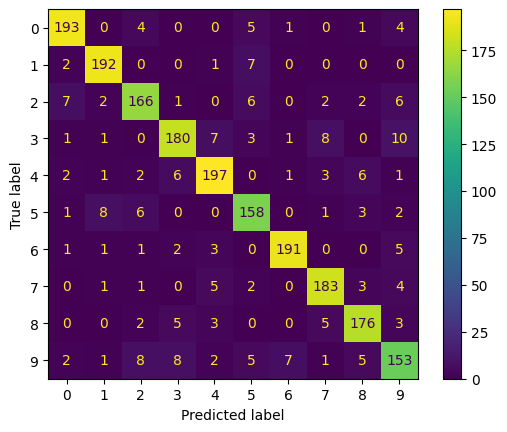

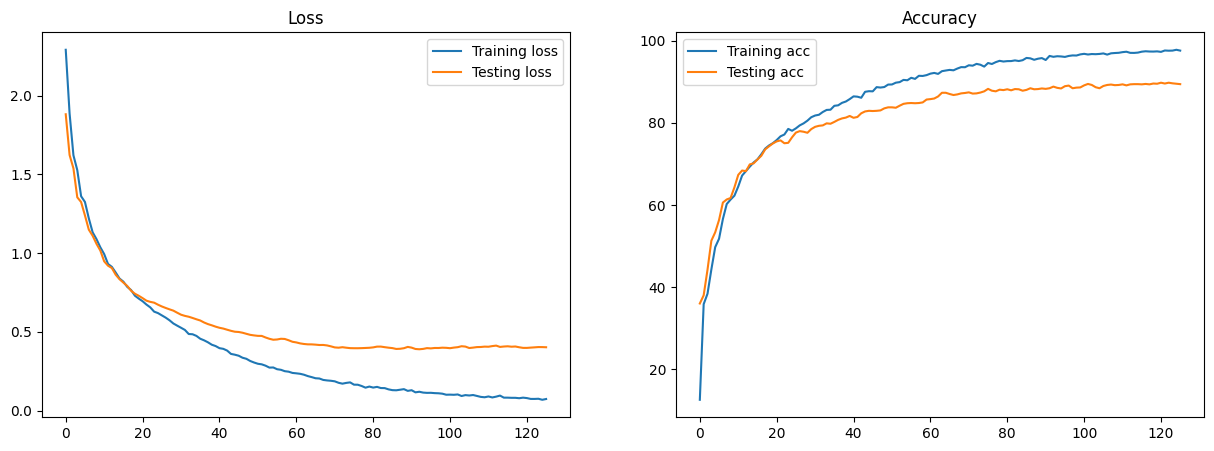

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       208
           1       0.93      0.95      0.94       202
           2       0.87      0.86      0.87       192
           3       0.89      0.85      0.87       211
           4       0.90      0.90      0.90       219
           5       0.85      0.88      0.87       179
           6       0.95      0.94      0.94       204
           7       0.90      0.92      0.91       199
           8       0.90      0.91      0.90       194
           9       0.81      0.80      0.81       192

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06643, Acc: 97.92% | Test Loss: 0.43870, Test Acc: 89.20%


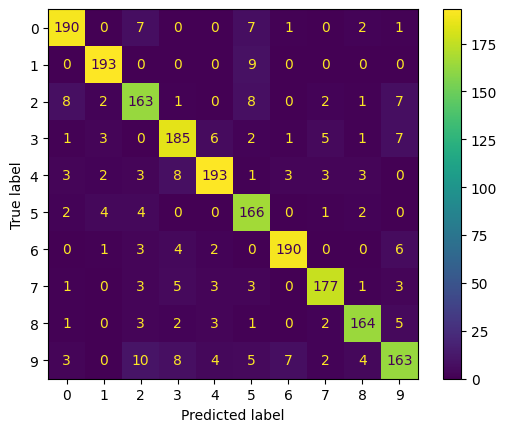

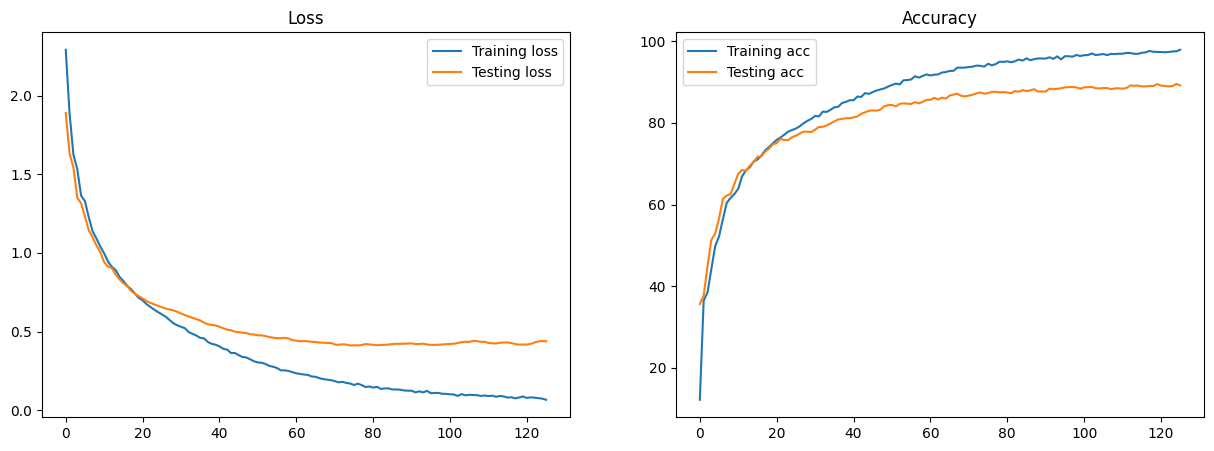

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       208
           1       0.94      0.96      0.95       202
           2       0.83      0.85      0.84       192
           3       0.87      0.88      0.87       211
           4       0.91      0.88      0.90       219
           5       0.82      0.93      0.87       179
           6       0.94      0.92      0.93       206
           7       0.92      0.90      0.91       196
           8       0.92      0.91      0.91       181
           9       0.85      0.79      0.82       206

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07001, Acc: 97.60% | Test Loss: 0.39724, Test Acc: 90.10%


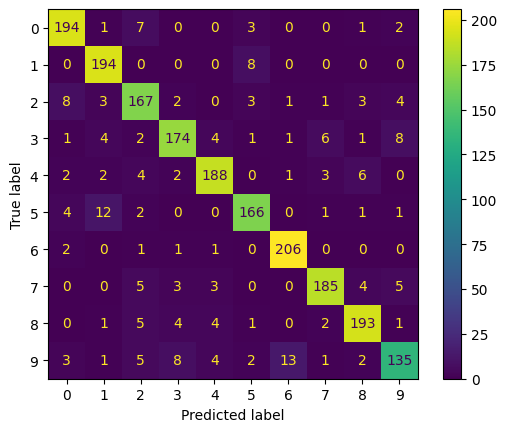

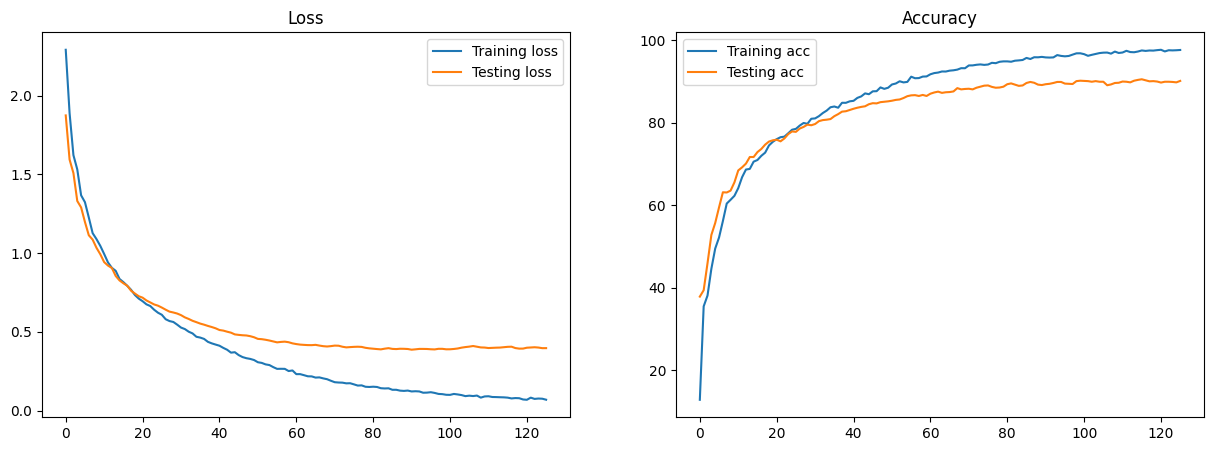

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       208
           1       0.89      0.96      0.92       202
           2       0.84      0.87      0.86       192
           3       0.90      0.86      0.88       202
           4       0.92      0.90      0.91       208
           5       0.90      0.89      0.89       187
           6       0.93      0.98      0.95       211
           7       0.93      0.90      0.92       205
           8       0.91      0.91      0.91       211
           9       0.87      0.78      0.82       174

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07563, Acc: 97.47% | Test Loss: 0.34766, Test Acc: 90.87%


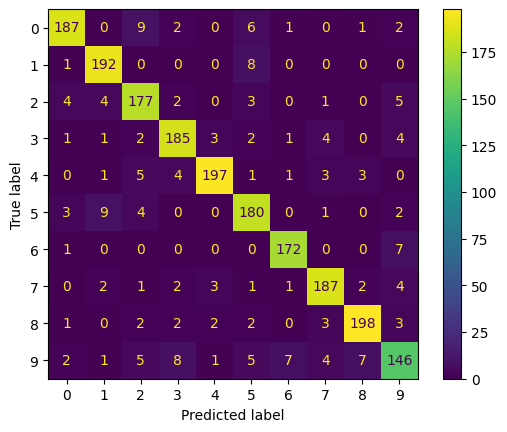

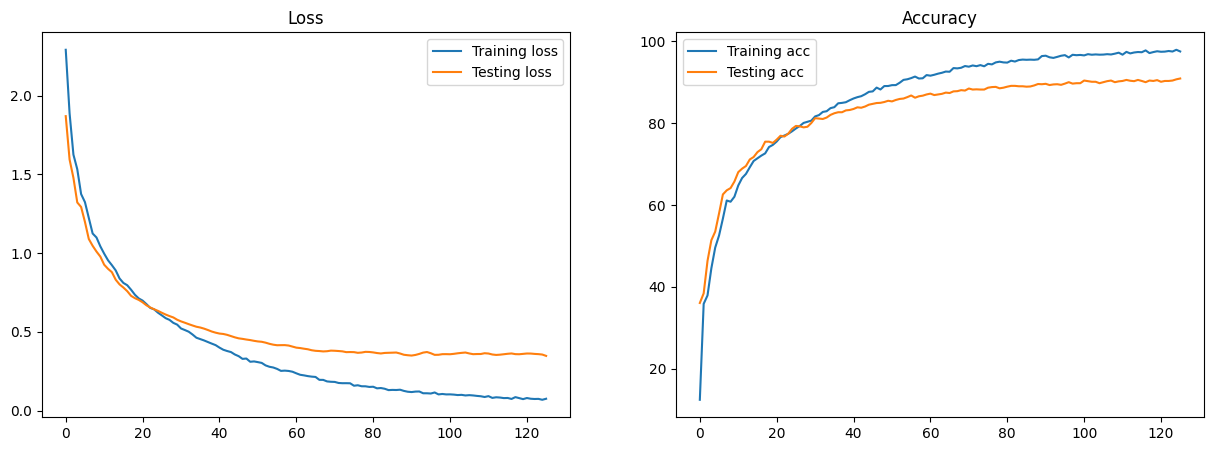

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       208
           1       0.91      0.96      0.93       201
           2       0.86      0.90      0.88       196
           3       0.90      0.91      0.91       203
           4       0.96      0.92      0.94       215
           5       0.87      0.90      0.88       199
           6       0.94      0.96      0.95       180
           7       0.92      0.92      0.92       203
           8       0.94      0.93      0.93       213
           9       0.84      0.78      0.81       186

    accuracy                           0.91      2004
   macro avg       0.91      0.91      0.91      2004
weighted avg       0.91      0.91      0.91      2004



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07247, Acc: 97.53% | Test Loss: 0.29780, Test Acc: 91.85%


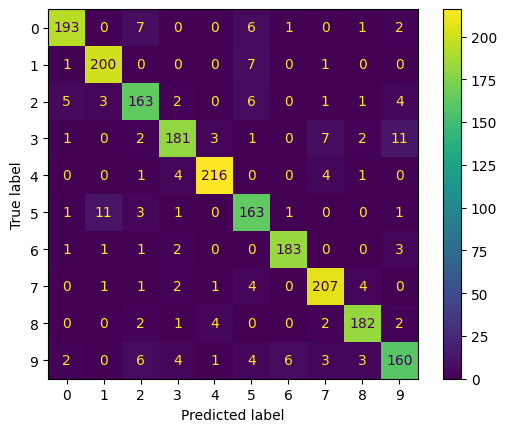

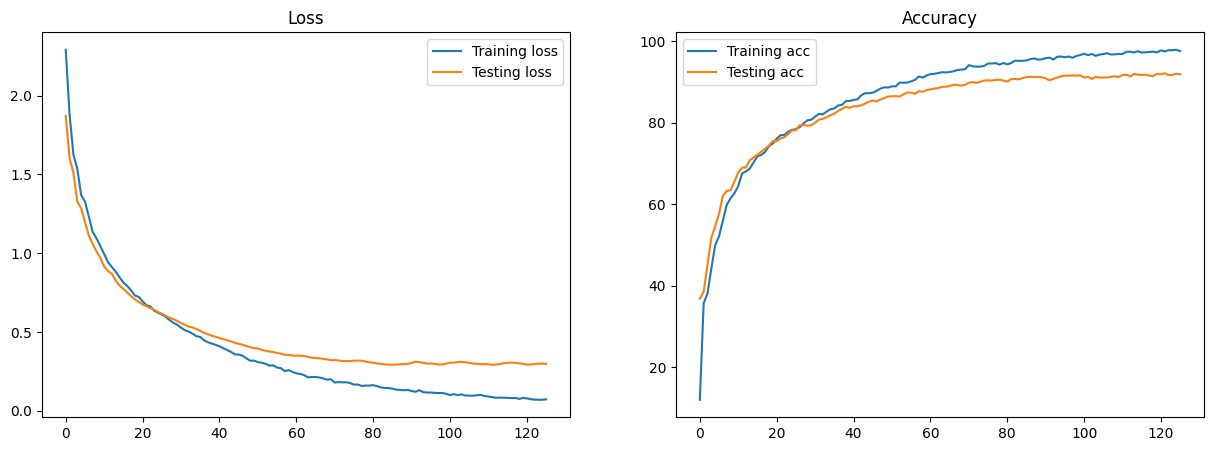

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       210
           1       0.93      0.96      0.94       209
           2       0.88      0.88      0.88       185
           3       0.92      0.87      0.89       208
           4       0.96      0.96      0.96       226
           5       0.85      0.90      0.88       181
           6       0.96      0.96      0.96       191
           7       0.92      0.94      0.93       220
           8       0.94      0.94      0.94       193
           9       0.87      0.85      0.86       189

    accuracy                           0.92      2012
   macro avg       0.92      0.92      0.92      2012
weighted avg       0.92      0.92      0.92      2012



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07293, Acc: 97.58% | Test Loss: 0.43762, Test Acc: 90.52%


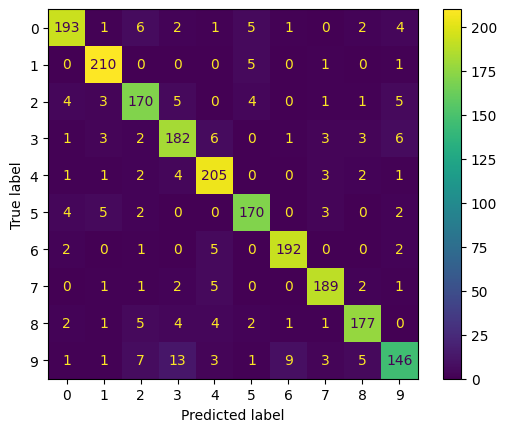

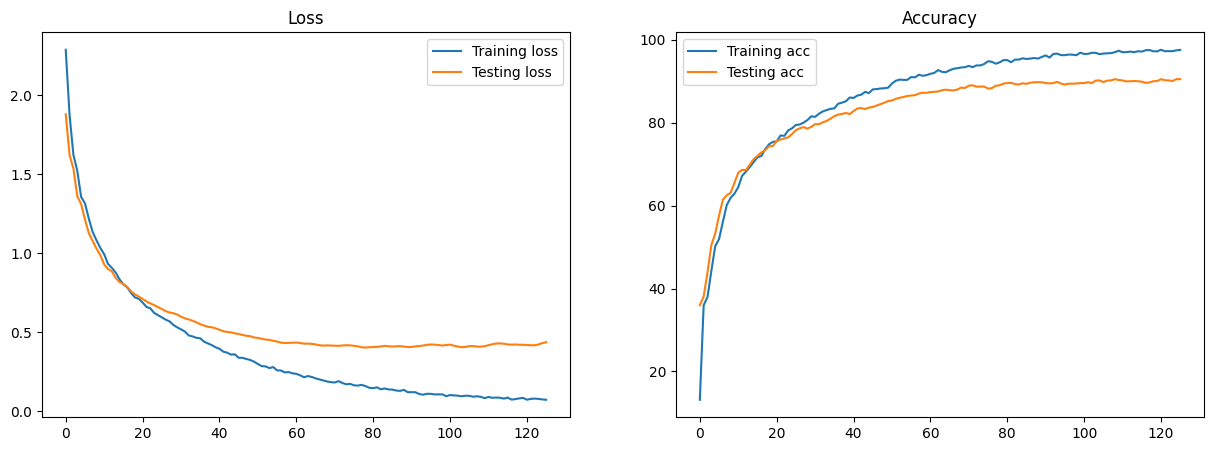

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       215
           1       0.93      0.97      0.95       217
           2       0.87      0.88      0.87       193
           3       0.86      0.88      0.87       207
           4       0.90      0.94      0.92       219
           5       0.91      0.91      0.91       186
           6       0.94      0.95      0.95       202
           7       0.93      0.94      0.93       201
           8       0.92      0.90      0.91       197
           9       0.87      0.77      0.82       189

    accuracy                           0.91      2026
   macro avg       0.90      0.90      0.90      2026
weighted avg       0.91      0.91      0.90      2026



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07288, Acc: 97.64% | Test Loss: 0.29581, Test Acc: 91.96%


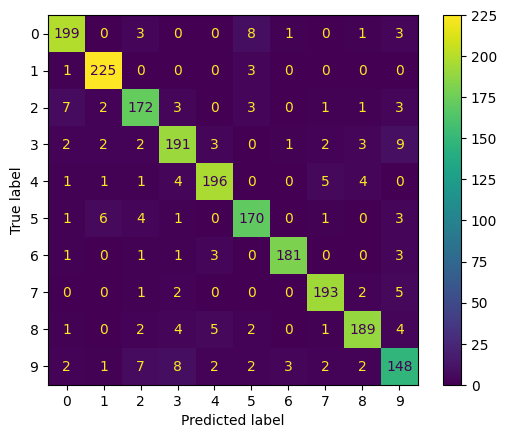

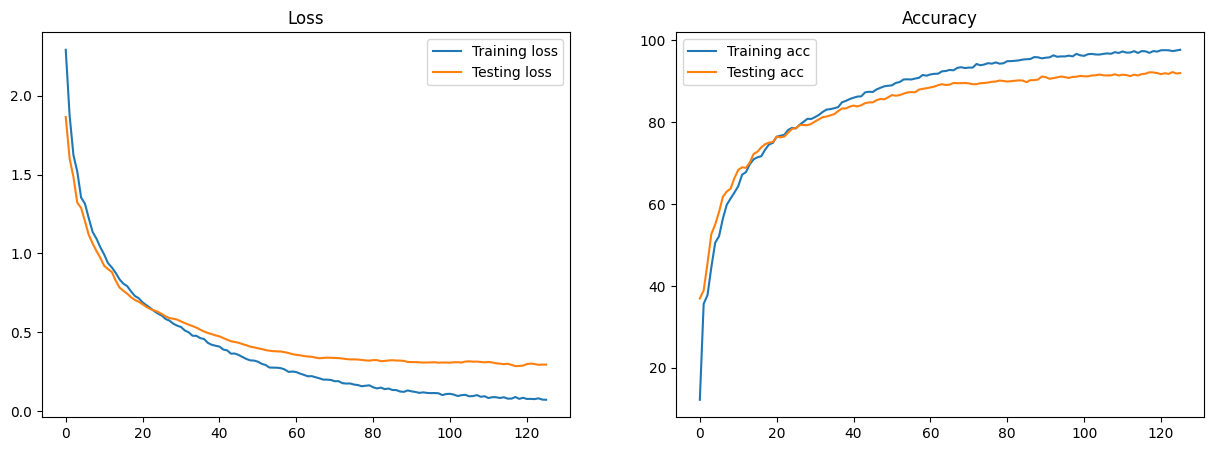

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       215
           1       0.95      0.98      0.97       229
           2       0.89      0.90      0.89       192
           3       0.89      0.89      0.89       215
           4       0.94      0.92      0.93       212
           5       0.90      0.91      0.91       186
           6       0.97      0.95      0.96       190
           7       0.94      0.95      0.95       203
           8       0.94      0.91      0.92       208
           9       0.83      0.84      0.83       177

    accuracy                           0.92      2027
   macro avg       0.92      0.92      0.92      2027
weighted avg       0.92      0.92      0.92      2027



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07701, Acc: 97.24% | Test Loss: 0.38244, Test Acc: 90.79%


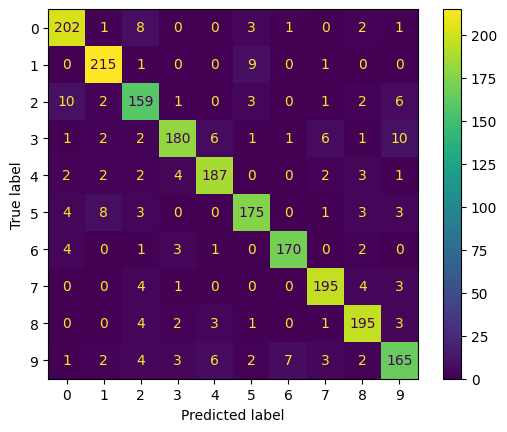

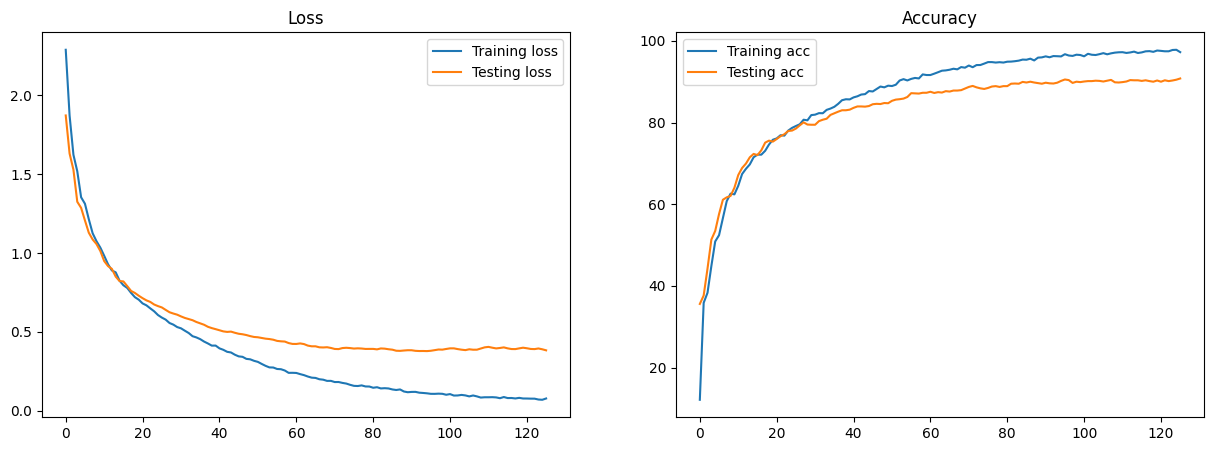

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       218
           1       0.93      0.95      0.94       226
           2       0.85      0.86      0.85       184
           3       0.93      0.86      0.89       210
           4       0.92      0.92      0.92       203
           5       0.90      0.89      0.90       197
           6       0.95      0.94      0.94       181
           7       0.93      0.94      0.94       207
           8       0.91      0.93      0.92       209
           9       0.86      0.85      0.85       195

    accuracy                           0.91      2030
   macro avg       0.91      0.91      0.91      2030
weighted avg       0.91      0.91      0.91      2030



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07069, Acc: 97.64% | Test Loss: 0.40891, Test Acc: 90.25%


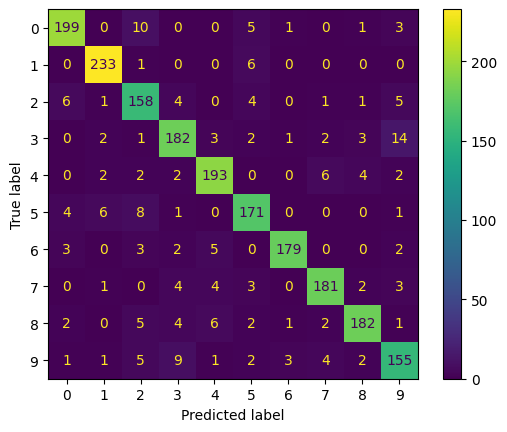

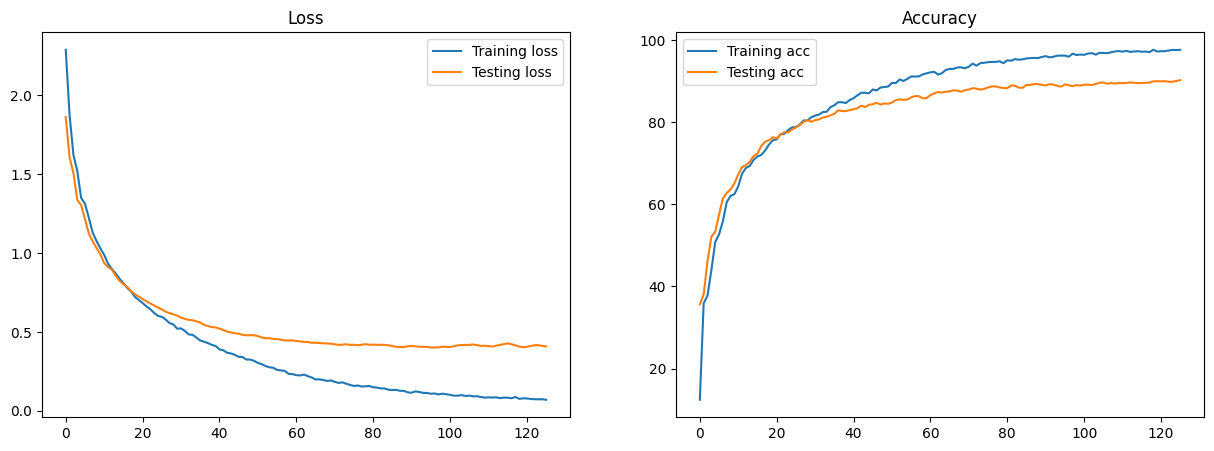

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       219
           1       0.95      0.97      0.96       240
           2       0.82      0.88      0.85       180
           3       0.88      0.87      0.87       210
           4       0.91      0.91      0.91       211
           5       0.88      0.90      0.89       191
           6       0.97      0.92      0.94       194
           7       0.92      0.91      0.92       198
           8       0.93      0.89      0.91       205
           9       0.83      0.85      0.84       183

    accuracy                           0.90      2031
   macro avg       0.90      0.90      0.90      2031
weighted avg       0.90      0.90      0.90      2031



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07733, Acc: 97.43% | Test Loss: 0.39039, Test Acc: 90.89%


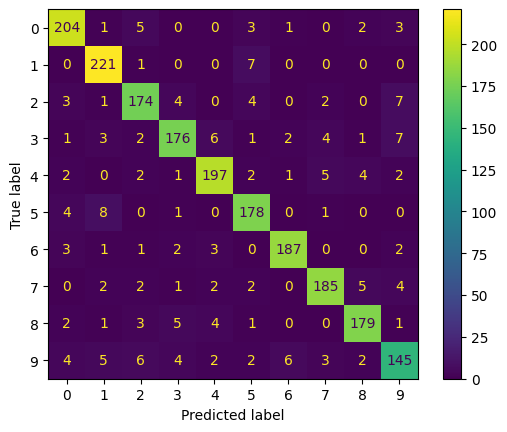

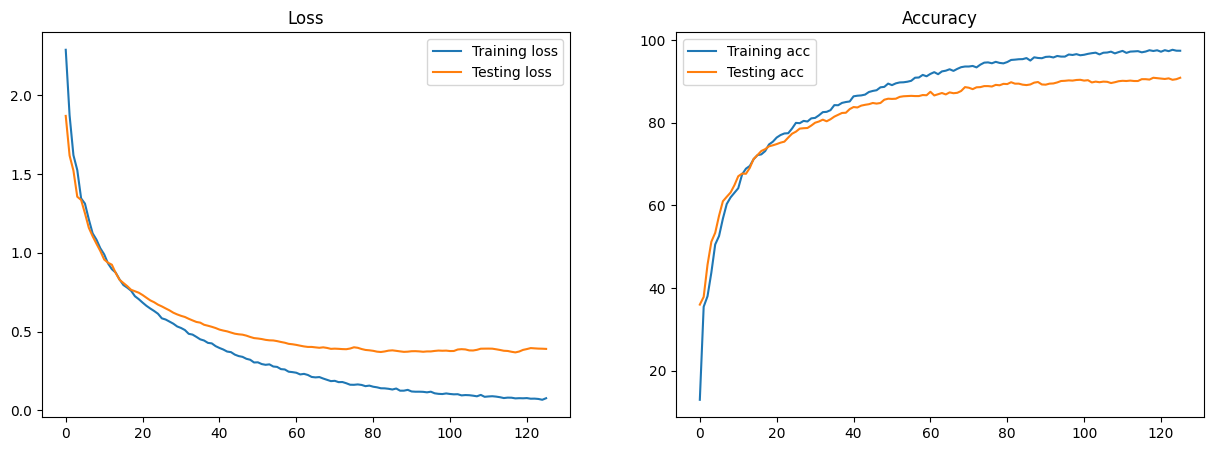

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       219
           1       0.91      0.97      0.94       229
           2       0.89      0.89      0.89       195
           3       0.91      0.87      0.89       203
           4       0.92      0.91      0.92       216
           5       0.89      0.93      0.91       192
           6       0.95      0.94      0.94       199
           7       0.93      0.91      0.92       203
           8       0.93      0.91      0.92       196
           9       0.85      0.81      0.83       179

    accuracy                           0.91      2031
   macro avg       0.91      0.91      0.91      2031
weighted avg       0.91      0.91      0.91      2031



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07773, Acc: 97.54% | Test Loss: 0.35852, Test Acc: 90.25%


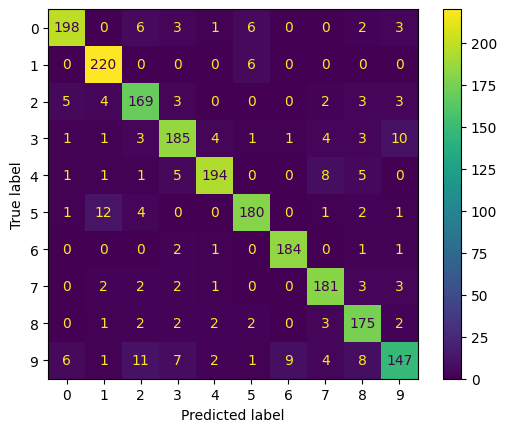

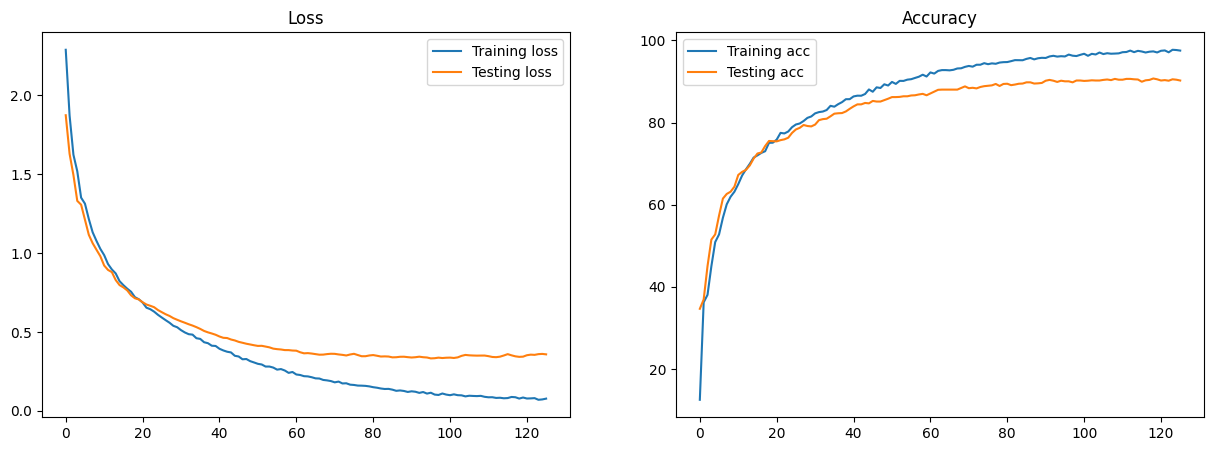

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       219
           1       0.91      0.97      0.94       226
           2       0.85      0.89      0.87       189
           3       0.89      0.87      0.88       213
           4       0.95      0.90      0.92       215
           5       0.92      0.90      0.91       201
           6       0.95      0.97      0.96       189
           7       0.89      0.93      0.91       194
           8       0.87      0.93      0.90       189
           9       0.86      0.75      0.80       196

    accuracy                           0.90      2031
   macro avg       0.90      0.90      0.90      2031
weighted avg       0.90      0.90      0.90      2031



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07773, Acc: 97.54% | Test Loss: 0.35852, Test Acc: 90.25%


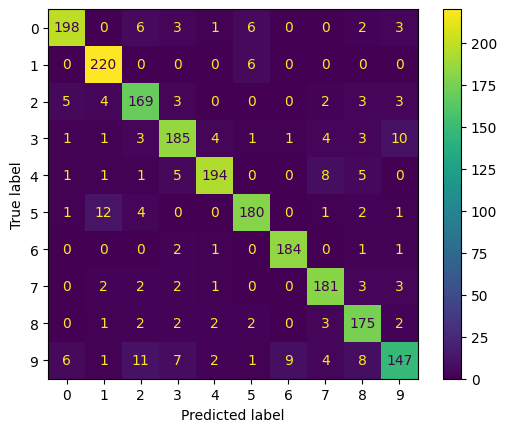

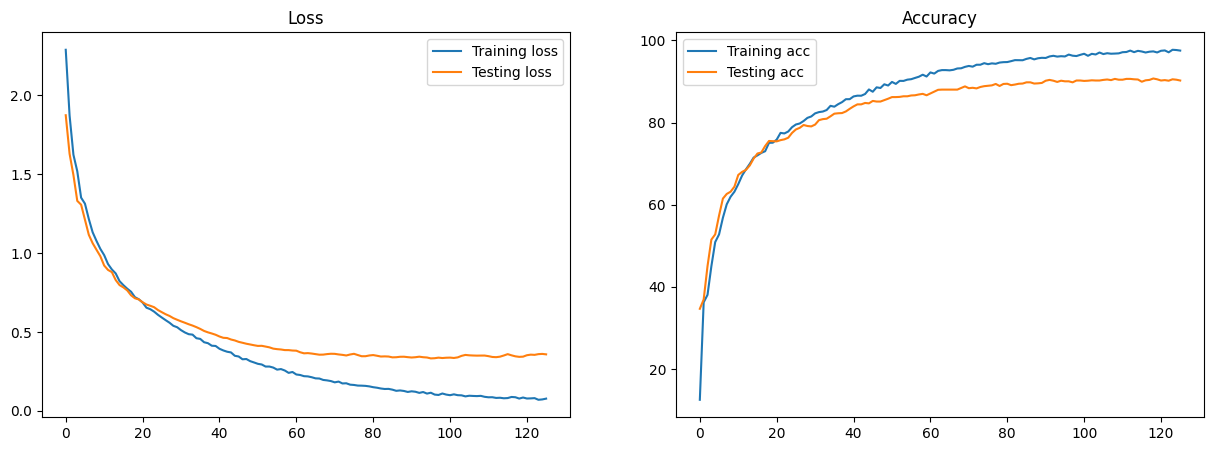

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       219
           1       0.91      0.97      0.94       226
           2       0.85      0.89      0.87       189
           3       0.89      0.87      0.88       213
           4       0.95      0.90      0.92       215
           5       0.92      0.90      0.91       201
           6       0.95      0.97      0.96       189
           7       0.89      0.93      0.91       194
           8       0.87      0.93      0.90       189
           9       0.86      0.75      0.80       196

    accuracy                           0.90      2031
   macro avg       0.90      0.90      0.90      2031
weighted avg       0.90      0.90      0.90      2031



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06890, Acc: 97.68% | Test Loss: 0.43306, Test Acc: 90.00%


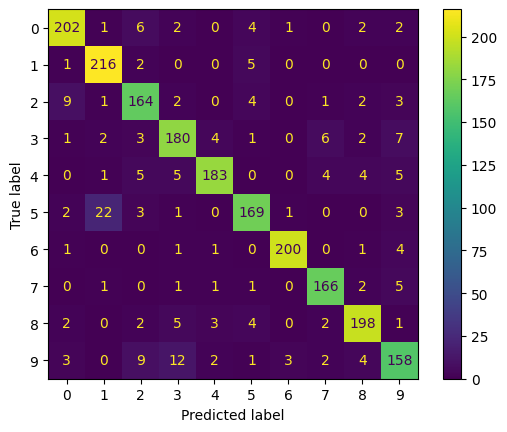

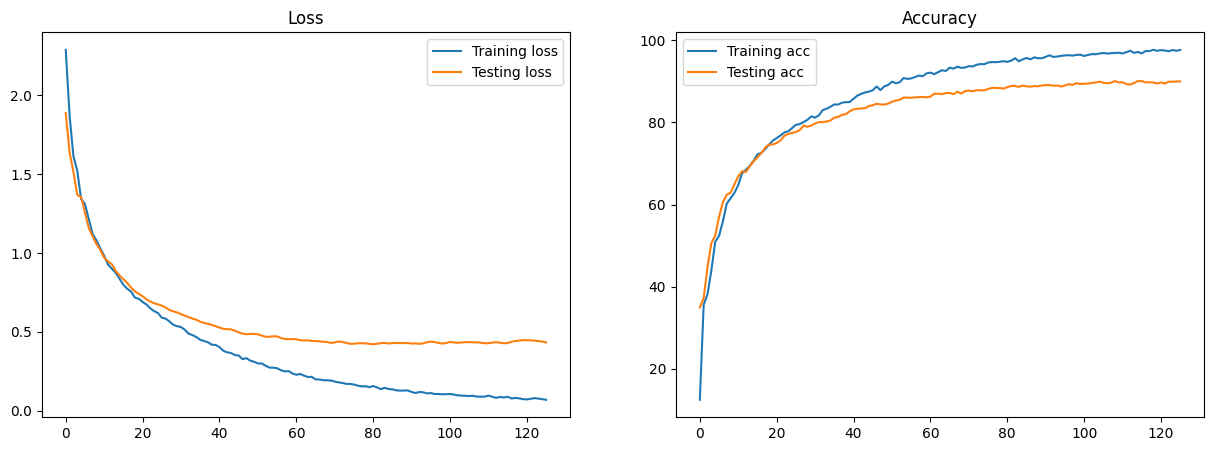

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       220
           1       0.89      0.96      0.92       224
           2       0.85      0.88      0.86       186
           3       0.86      0.87      0.87       206
           4       0.94      0.88      0.91       207
           5       0.89      0.84      0.87       201
           6       0.98      0.96      0.97       208
           7       0.92      0.94      0.93       177
           8       0.92      0.91      0.92       217
           9       0.84      0.81      0.83       194

    accuracy                           0.90      2040
   macro avg       0.90      0.90      0.90      2040
weighted avg       0.90      0.90      0.90      2040



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06766, Acc: 97.70% | Test Loss: 0.32502, Test Acc: 91.48%


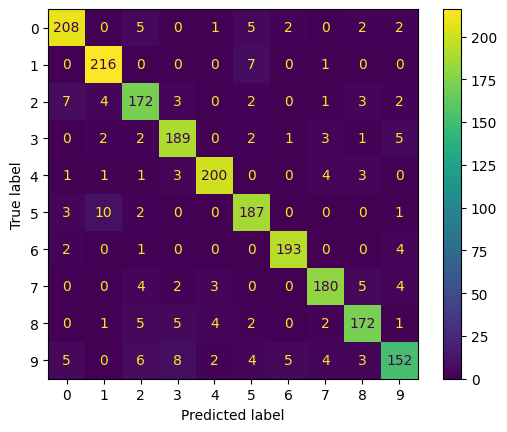

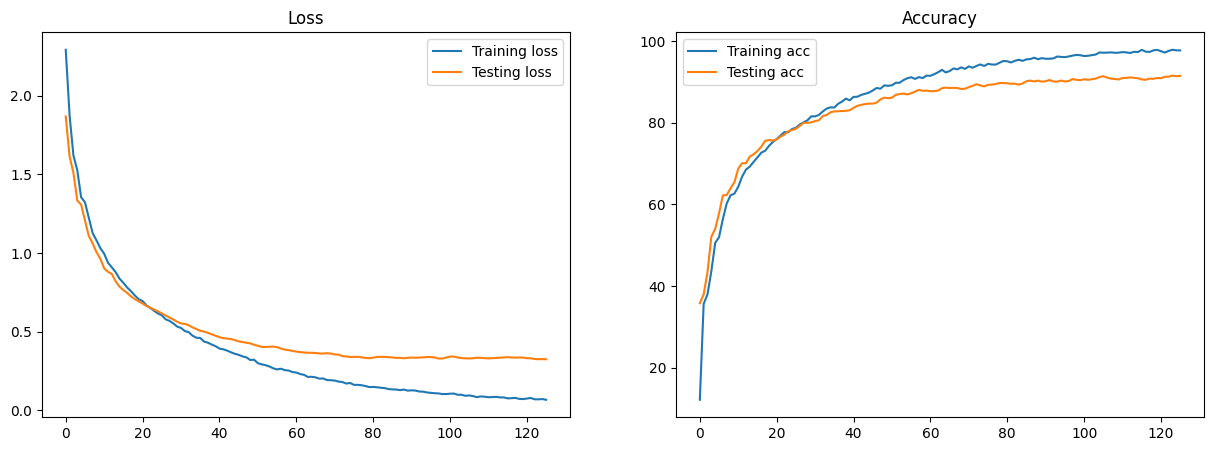

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       225
           1       0.92      0.96      0.94       224
           2       0.87      0.89      0.88       194
           3       0.90      0.92      0.91       205
           4       0.95      0.94      0.95       213
           5       0.89      0.92      0.91       203
           6       0.96      0.96      0.96       200
           7       0.92      0.91      0.92       198
           8       0.91      0.90      0.90       192
           9       0.89      0.80      0.84       189

    accuracy                           0.91      2043
   macro avg       0.91      0.91      0.91      2043
weighted avg       0.91      0.91      0.91      2043



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07287, Acc: 97.59% | Test Loss: 0.32890, Test Acc: 91.83%


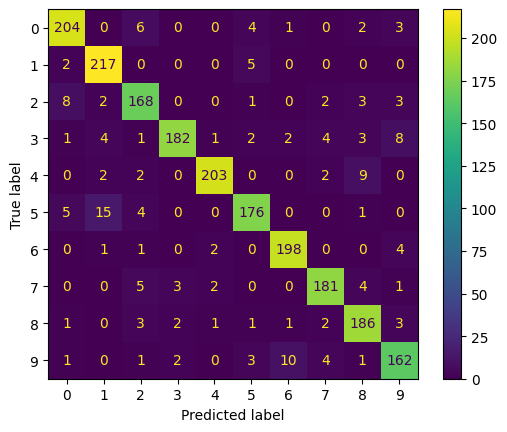

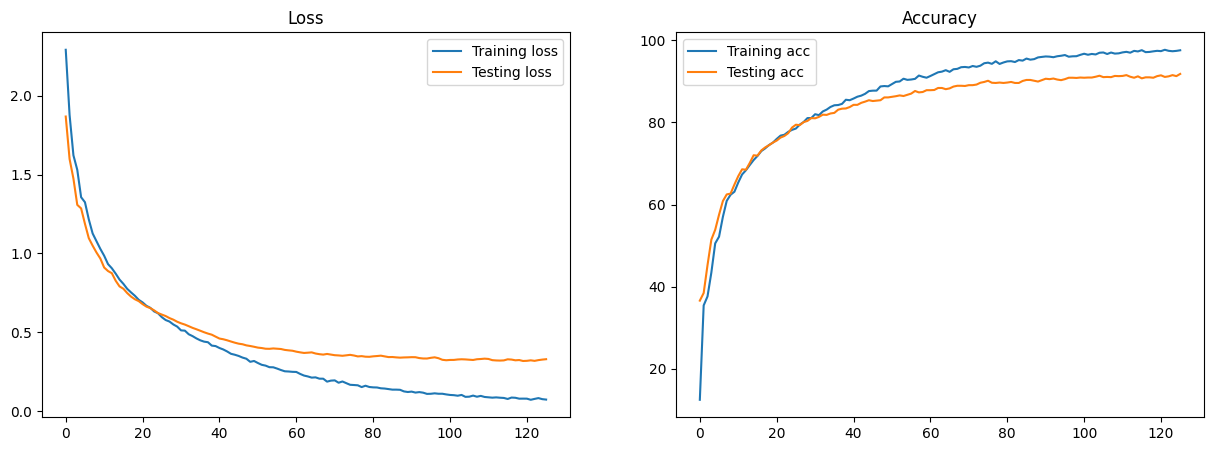

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       220
           1       0.90      0.97      0.93       224
           2       0.88      0.90      0.89       187
           3       0.96      0.88      0.92       208
           4       0.97      0.93      0.95       218
           5       0.92      0.88      0.90       201
           6       0.93      0.96      0.95       206
           7       0.93      0.92      0.93       196
           8       0.89      0.93      0.91       200
           9       0.88      0.88      0.88       184

    accuracy                           0.92      2044
   macro avg       0.92      0.92      0.92      2044
weighted avg       0.92      0.92      0.92      2044



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06747, Acc: 97.83% | Test Loss: 0.35593, Test Acc: 91.14%


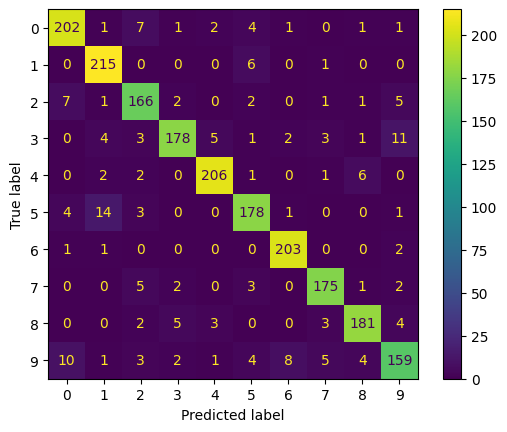

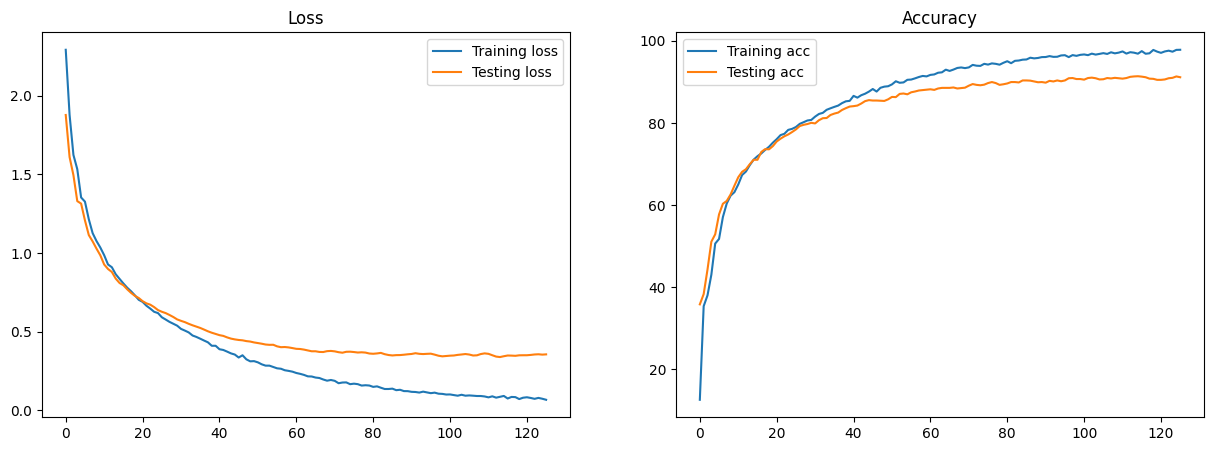

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       220
           1       0.90      0.97      0.93       222
           2       0.87      0.90      0.88       185
           3       0.94      0.86      0.89       208
           4       0.95      0.94      0.95       218
           5       0.89      0.89      0.89       201
           6       0.94      0.98      0.96       207
           7       0.93      0.93      0.93       188
           8       0.93      0.91      0.92       198
           9       0.86      0.81      0.83       197

    accuracy                           0.91      2044
   macro avg       0.91      0.91      0.91      2044
weighted avg       0.91      0.91      0.91      2044



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.06747, Acc: 97.83% | Test Loss: 0.35593, Test Acc: 91.14%


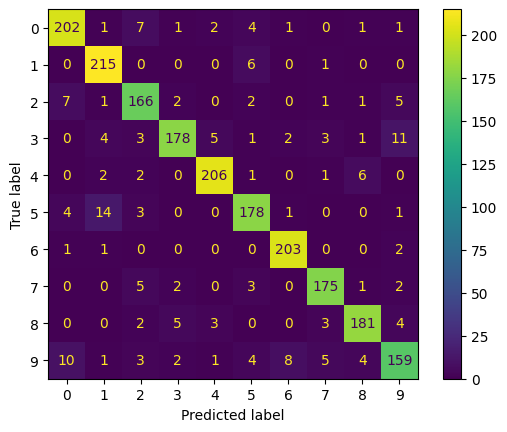

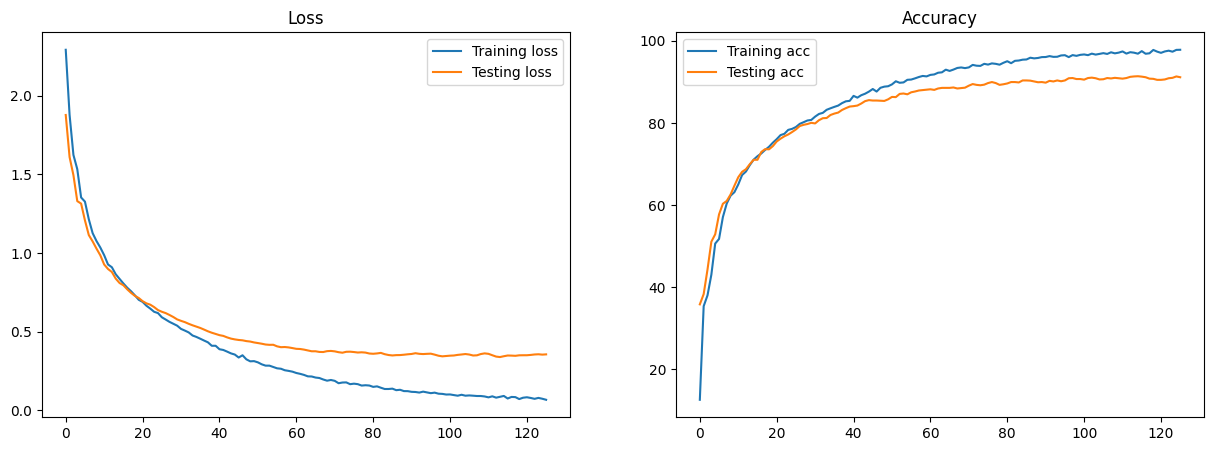

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       220
           1       0.90      0.97      0.93       222
           2       0.87      0.90      0.88       185
           3       0.94      0.86      0.89       208
           4       0.95      0.94      0.95       218
           5       0.89      0.89      0.89       201
           6       0.94      0.98      0.96       207
           7       0.93      0.93      0.93       188
           8       0.93      0.91      0.92       198
           9       0.86      0.81      0.83       197

    accuracy                           0.91      2044
   macro avg       0.91      0.91      0.91      2044
weighted avg       0.91      0.91      0.91      2044



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.06747, Acc: 97.83% | Test Loss: 0.35593, Test Acc: 91.14%


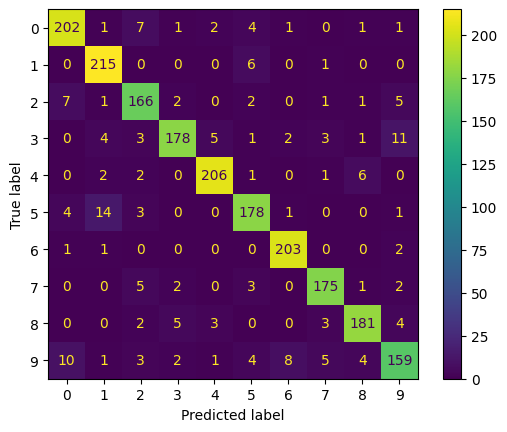

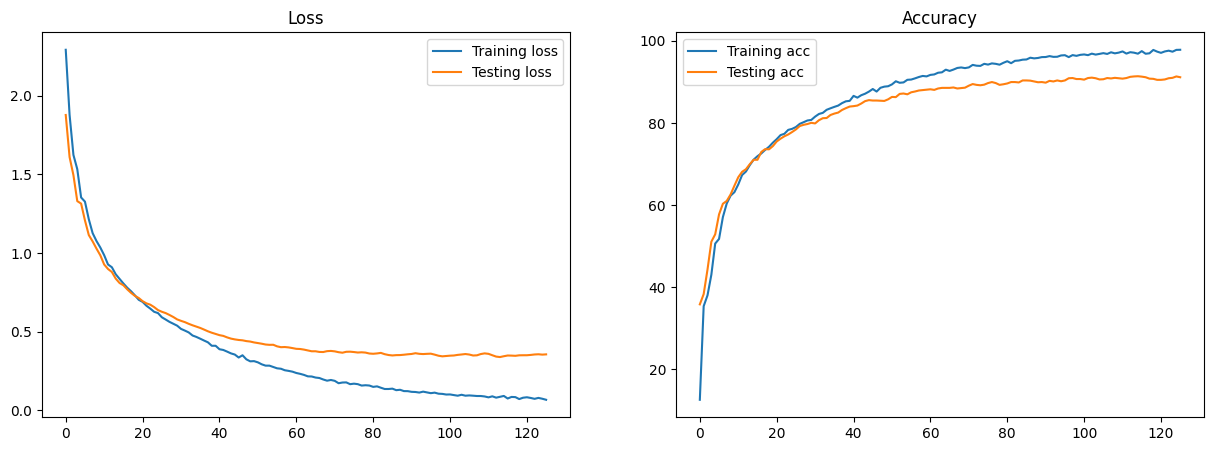

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       220
           1       0.90      0.97      0.93       222
           2       0.87      0.90      0.88       185
           3       0.94      0.86      0.89       208
           4       0.95      0.94      0.95       218
           5       0.89      0.89      0.89       201
           6       0.94      0.98      0.96       207
           7       0.93      0.93      0.93       188
           8       0.93      0.91      0.92       198
           9       0.86      0.81      0.83       197

    accuracy                           0.91      2044
   macro avg       0.91      0.91      0.91      2044
weighted avg       0.91      0.91      0.91      2044



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07496, Acc: 97.59% | Test Loss: 0.35092, Test Acc: 91.06%


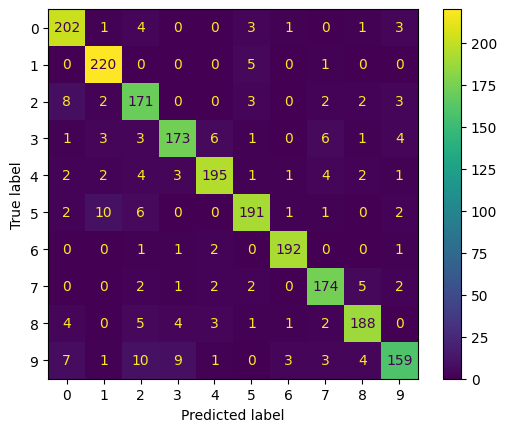

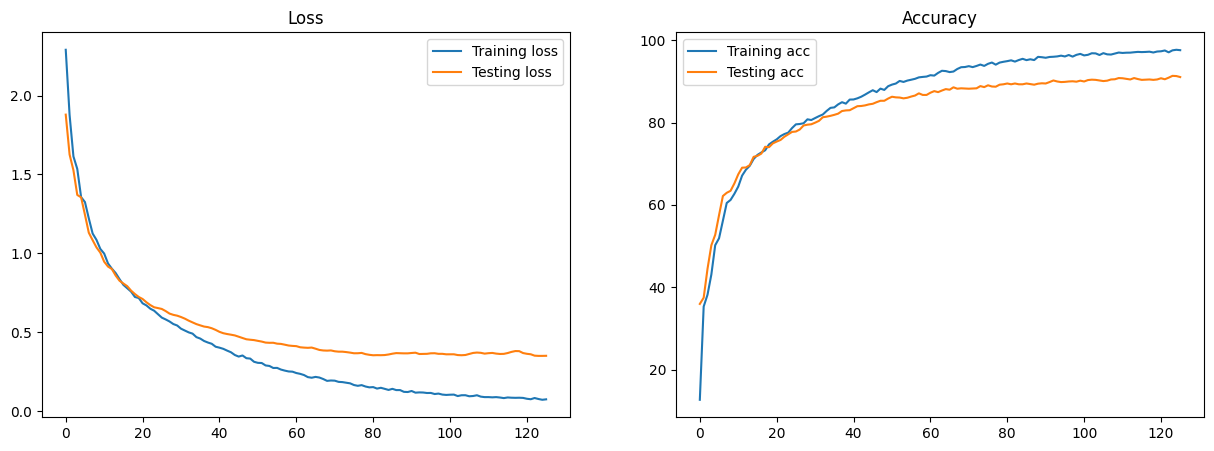

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       215
           1       0.92      0.97      0.95       226
           2       0.83      0.90      0.86       191
           3       0.91      0.87      0.89       198
           4       0.93      0.91      0.92       215
           5       0.92      0.90      0.91       213
           6       0.96      0.97      0.97       197
           7       0.90      0.93      0.91       188
           8       0.93      0.90      0.91       208
           9       0.91      0.81      0.85       197

    accuracy                           0.91      2048
   macro avg       0.91      0.91      0.91      2048
weighted avg       0.91      0.91      0.91      2048



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07283, Acc: 97.71% | Test Loss: 0.33677, Test Acc: 91.18%


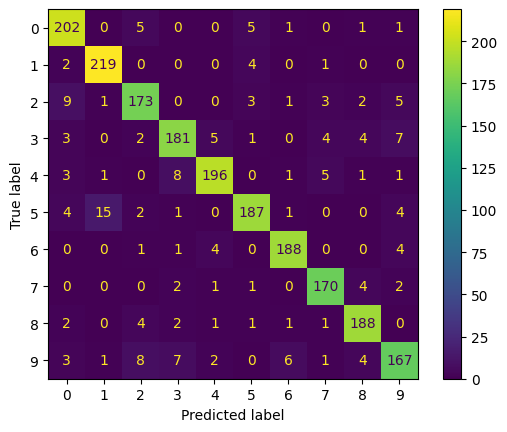

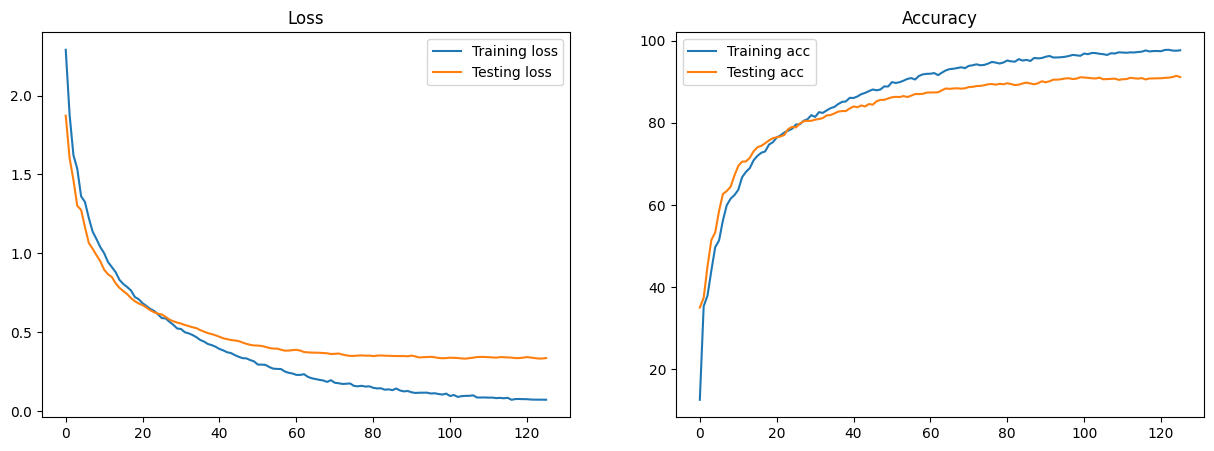

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       215
           1       0.92      0.97      0.95       226
           2       0.89      0.88      0.88       197
           3       0.90      0.87      0.89       207
           4       0.94      0.91      0.92       216
           5       0.93      0.87      0.90       214
           6       0.94      0.95      0.95       198
           7       0.92      0.94      0.93       180
           8       0.92      0.94      0.93       200
           9       0.87      0.84      0.86       199

    accuracy                           0.91      2052
   macro avg       0.91      0.91      0.91      2052
weighted avg       0.91      0.91      0.91      2052



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07607, Acc: 97.61% | Test Loss: 0.37706, Test Acc: 90.80%


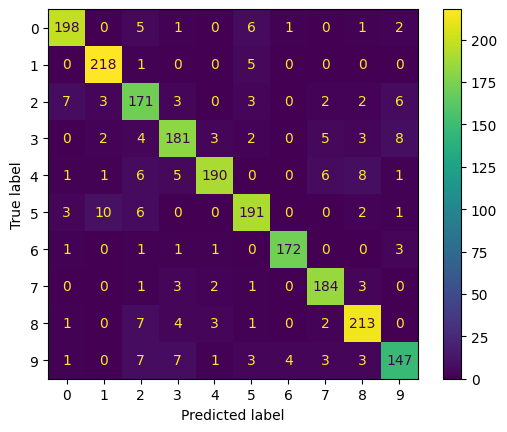

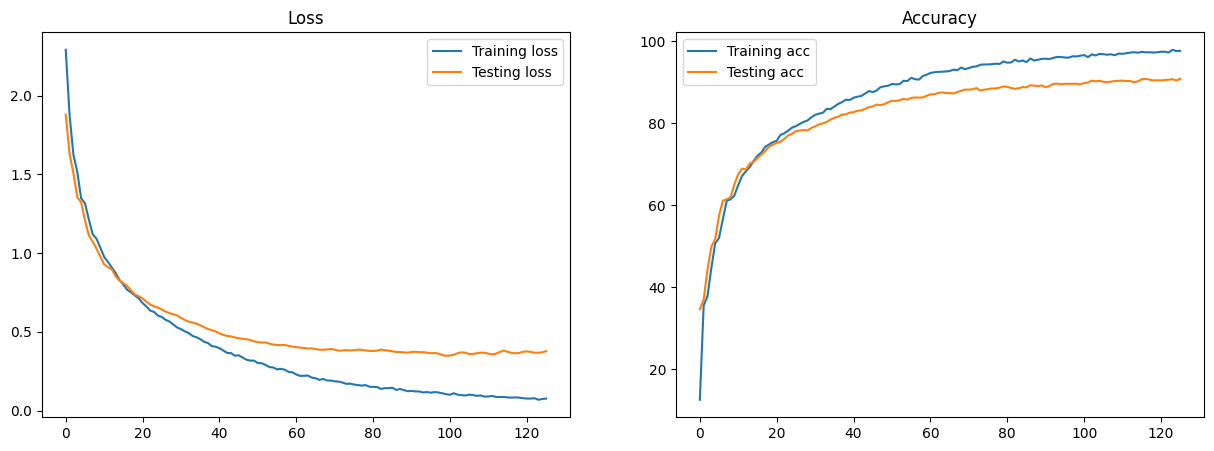

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       214
           1       0.93      0.97      0.95       224
           2       0.82      0.87      0.84       197
           3       0.88      0.87      0.88       208
           4       0.95      0.87      0.91       218
           5       0.90      0.90      0.90       213
           6       0.97      0.96      0.97       179
           7       0.91      0.95      0.93       194
           8       0.91      0.92      0.91       231
           9       0.88      0.84      0.85       176

    accuracy                           0.91      2054
   macro avg       0.91      0.91      0.91      2054
weighted avg       0.91      0.91      0.91      2054



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07607, Acc: 97.61% | Test Loss: 0.37706, Test Acc: 90.80%


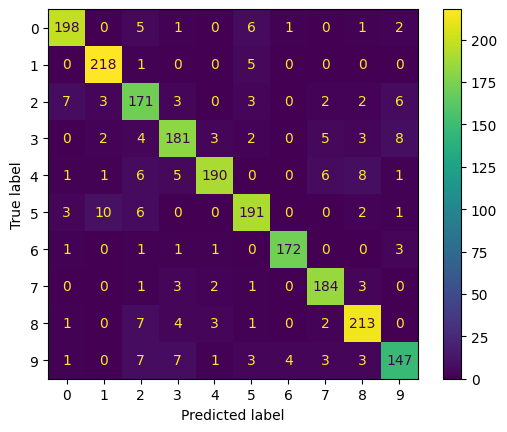

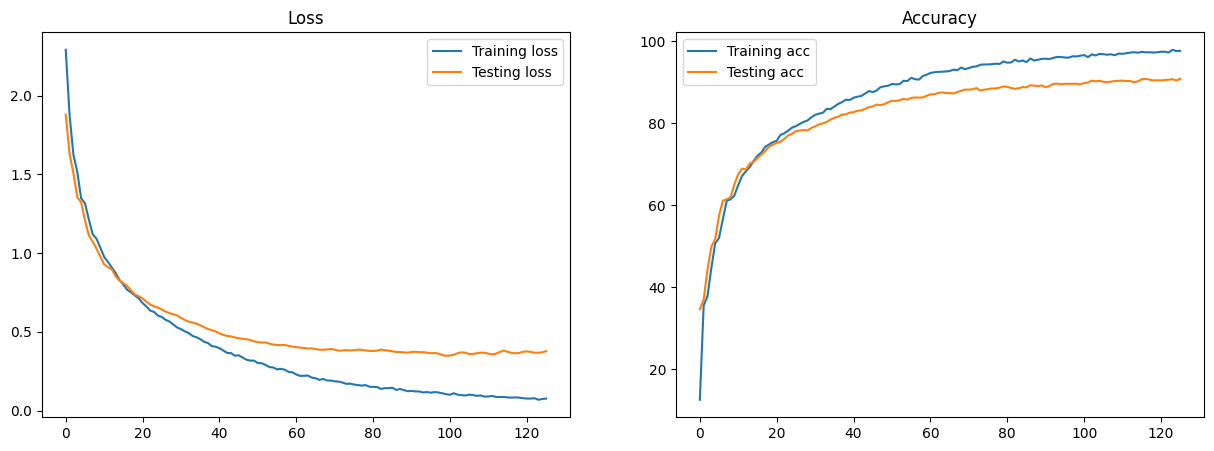

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       214
           1       0.93      0.97      0.95       224
           2       0.82      0.87      0.84       197
           3       0.88      0.87      0.88       208
           4       0.95      0.87      0.91       218
           5       0.90      0.90      0.90       213
           6       0.97      0.96      0.97       179
           7       0.91      0.95      0.93       194
           8       0.91      0.92      0.91       231
           9       0.88      0.84      0.85       176

    accuracy                           0.91      2054
   macro avg       0.91      0.91      0.91      2054
weighted avg       0.91      0.91      0.91      2054



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07607, Acc: 97.61% | Test Loss: 0.37706, Test Acc: 90.80%


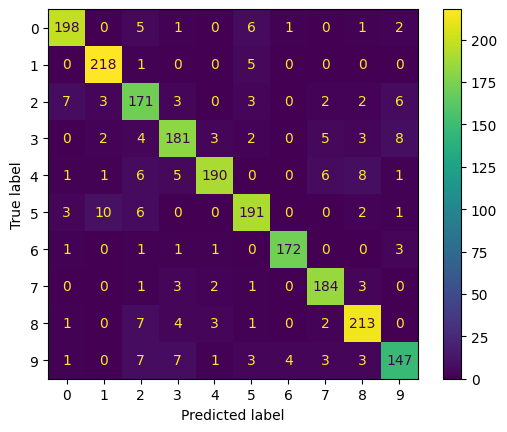

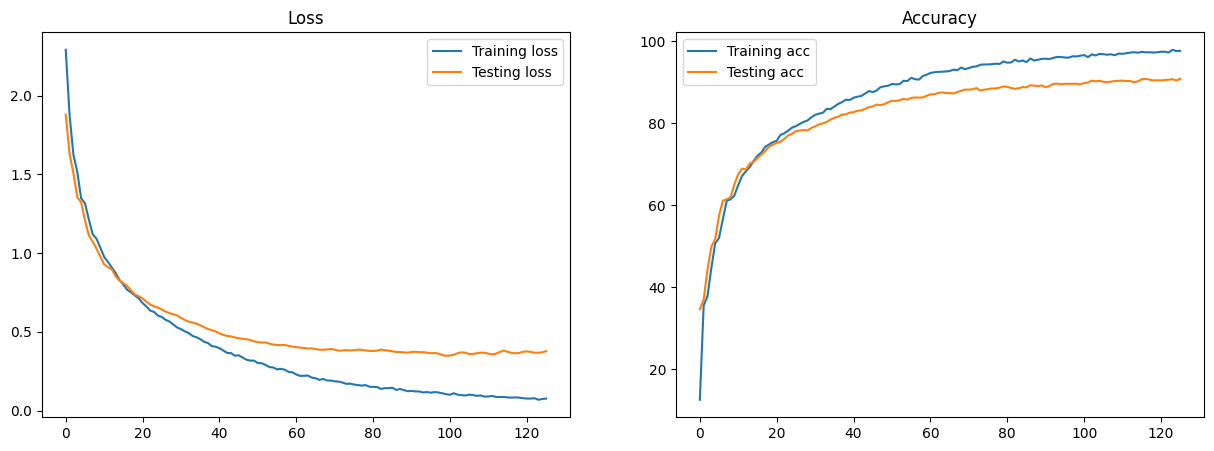

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       214
           1       0.93      0.97      0.95       224
           2       0.82      0.87      0.84       197
           3       0.88      0.87      0.88       208
           4       0.95      0.87      0.91       218
           5       0.90      0.90      0.90       213
           6       0.97      0.96      0.97       179
           7       0.91      0.95      0.93       194
           8       0.91      0.92      0.91       231
           9       0.88      0.84      0.85       176

    accuracy                           0.91      2054
   macro avg       0.91      0.91      0.91      2054
weighted avg       0.91      0.91      0.91      2054



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07581, Acc: 97.57% | Test Loss: 0.42442, Test Acc: 90.52%


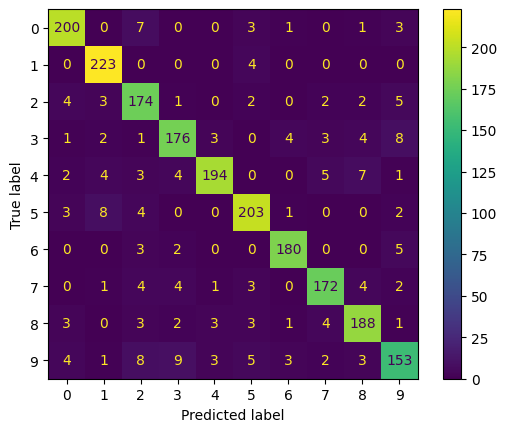

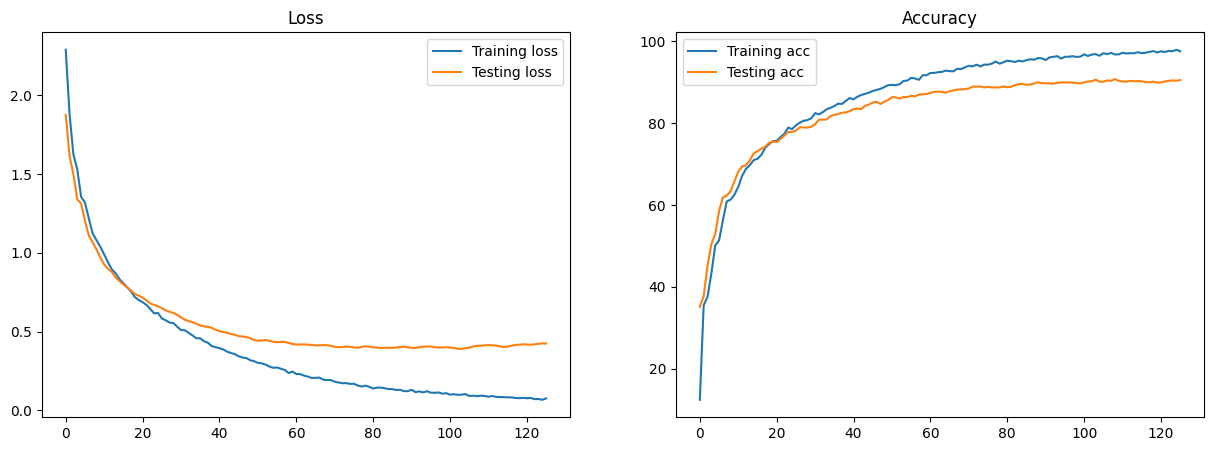

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       215
           1       0.92      0.98      0.95       227
           2       0.84      0.90      0.87       193
           3       0.89      0.87      0.88       202
           4       0.95      0.88      0.92       220
           5       0.91      0.92      0.91       221
           6       0.95      0.95      0.95       190
           7       0.91      0.90      0.91       191
           8       0.90      0.90      0.90       208
           9       0.85      0.80      0.82       191

    accuracy                           0.91      2058
   macro avg       0.90      0.90      0.90      2058
weighted avg       0.91      0.91      0.90      2058



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07053, Acc: 97.76% | Test Loss: 0.38209, Test Acc: 90.67%


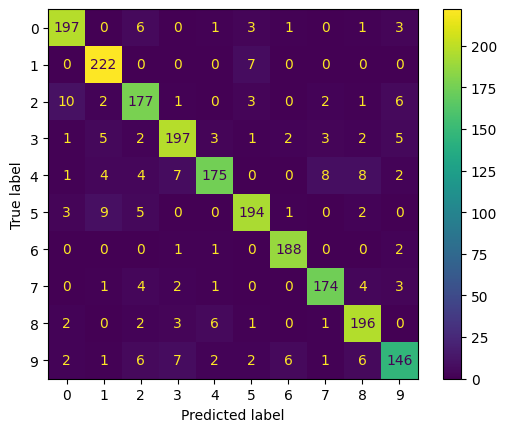

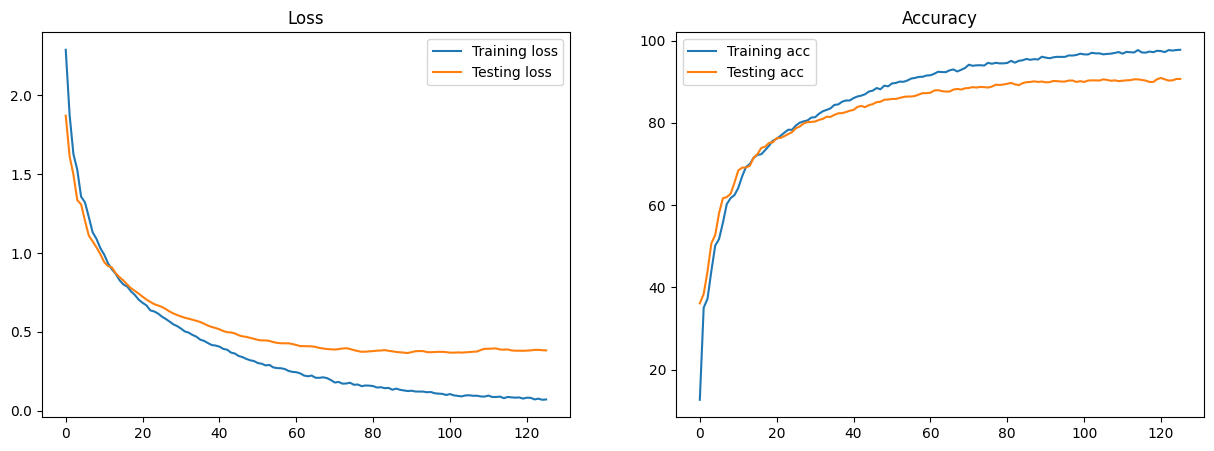

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       212
           1       0.91      0.97      0.94       229
           2       0.86      0.88      0.87       202
           3       0.90      0.89      0.90       221
           4       0.93      0.84      0.88       209
           5       0.92      0.91      0.91       214
           6       0.95      0.98      0.96       192
           7       0.92      0.92      0.92       189
           8       0.89      0.93      0.91       211
           9       0.87      0.82      0.84       179

    accuracy                           0.91      2058
   macro avg       0.91      0.91      0.91      2058
weighted avg       0.91      0.91      0.91      2058



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07480, Acc: 97.42% | Test Loss: 0.36395, Test Acc: 91.23%


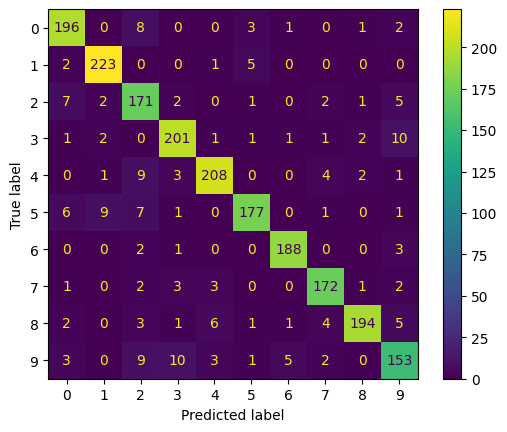

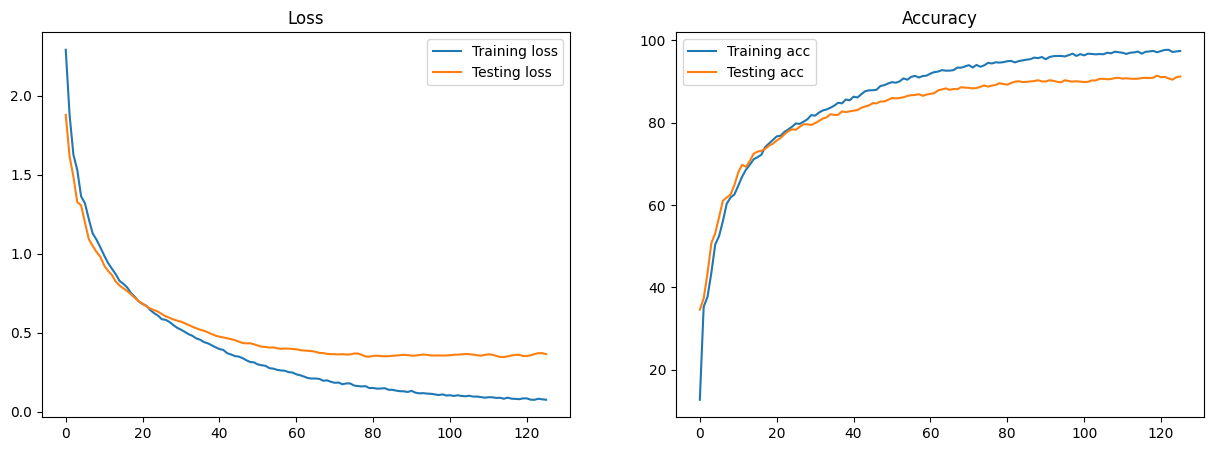

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       211
           1       0.94      0.97      0.95       231
           2       0.81      0.90      0.85       191
           3       0.91      0.91      0.91       220
           4       0.94      0.91      0.92       228
           5       0.94      0.88      0.91       202
           6       0.96      0.97      0.96       194
           7       0.92      0.93      0.93       184
           8       0.97      0.89      0.93       217
           9       0.84      0.82      0.83       186

    accuracy                           0.91      2064
   macro avg       0.91      0.91      0.91      2064
weighted avg       0.91      0.91      0.91      2064



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06508, Acc: 98.04% | Test Loss: 0.36011, Test Acc: 91.04%


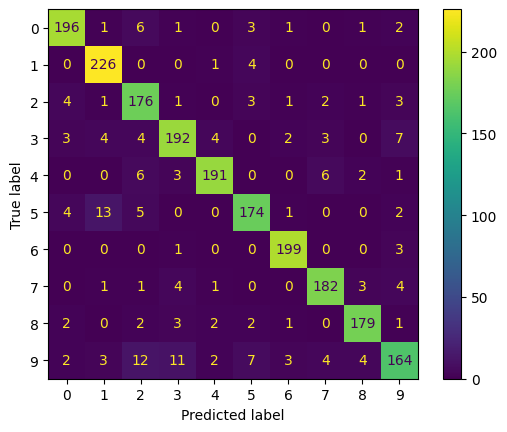

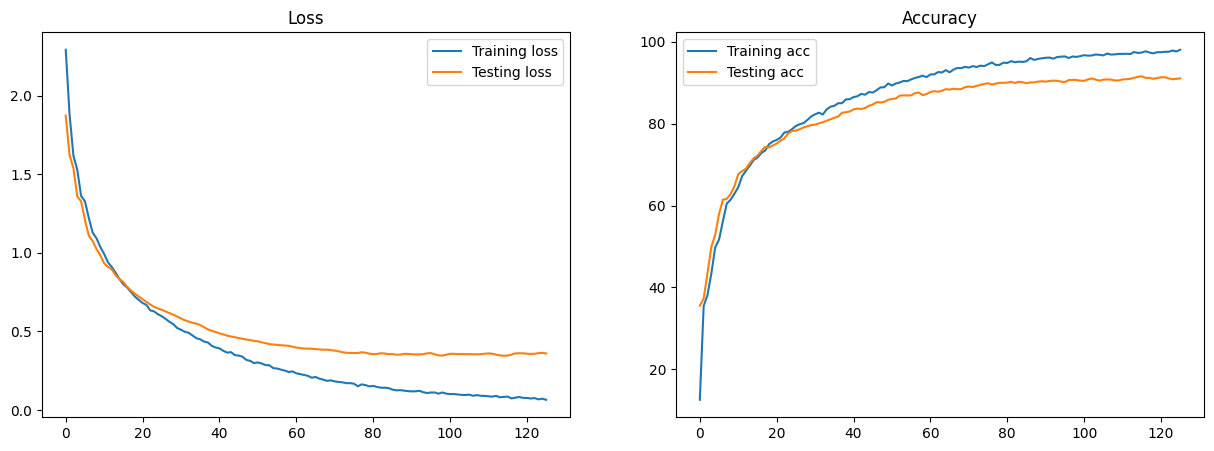

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       211
           1       0.91      0.98      0.94       231
           2       0.83      0.92      0.87       192
           3       0.89      0.88      0.88       219
           4       0.95      0.91      0.93       209
           5       0.90      0.87      0.89       199
           6       0.96      0.98      0.97       203
           7       0.92      0.93      0.93       196
           8       0.94      0.93      0.94       192
           9       0.88      0.77      0.82       212

    accuracy                           0.91      2064
   macro avg       0.91      0.91      0.91      2064
weighted avg       0.91      0.91      0.91      2064



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07362, Acc: 97.59% | Test Loss: 0.38896, Test Acc: 90.80%


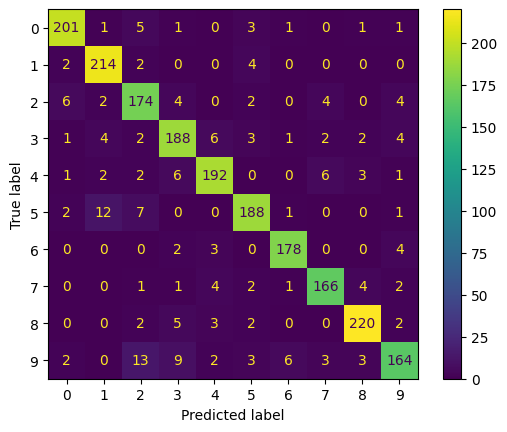

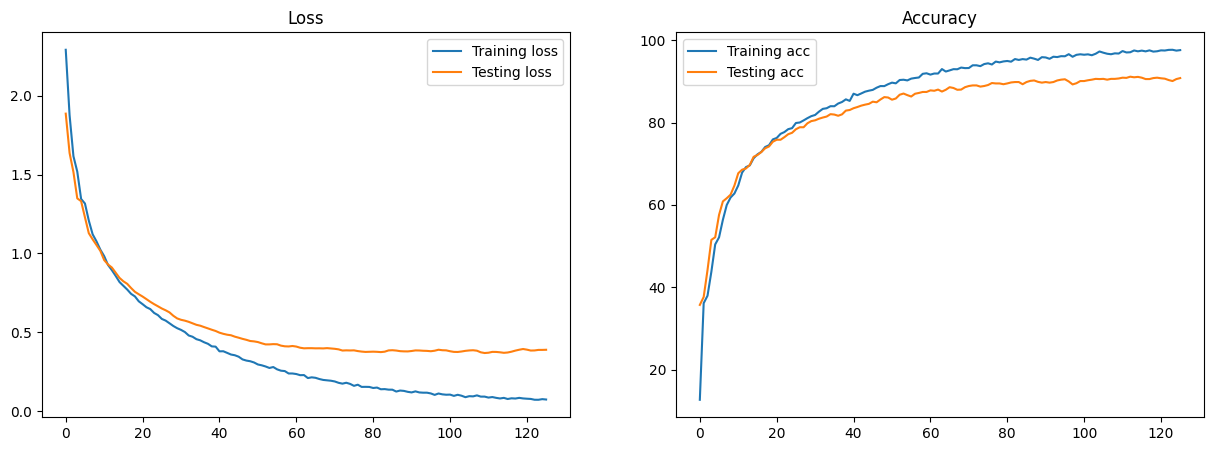

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       214
           1       0.91      0.96      0.94       222
           2       0.84      0.89      0.86       196
           3       0.87      0.88      0.88       213
           4       0.91      0.90      0.91       213
           5       0.91      0.89      0.90       211
           6       0.95      0.95      0.95       187
           7       0.92      0.92      0.92       181
           8       0.94      0.94      0.94       234
           9       0.90      0.80      0.85       205

    accuracy                           0.91      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.91      0.91      0.91      2076



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07362, Acc: 97.59% | Test Loss: 0.38896, Test Acc: 90.80%


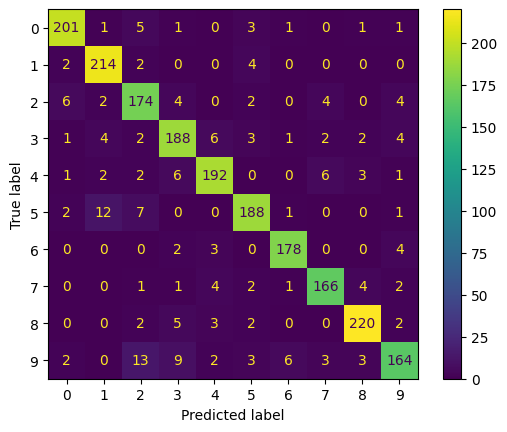

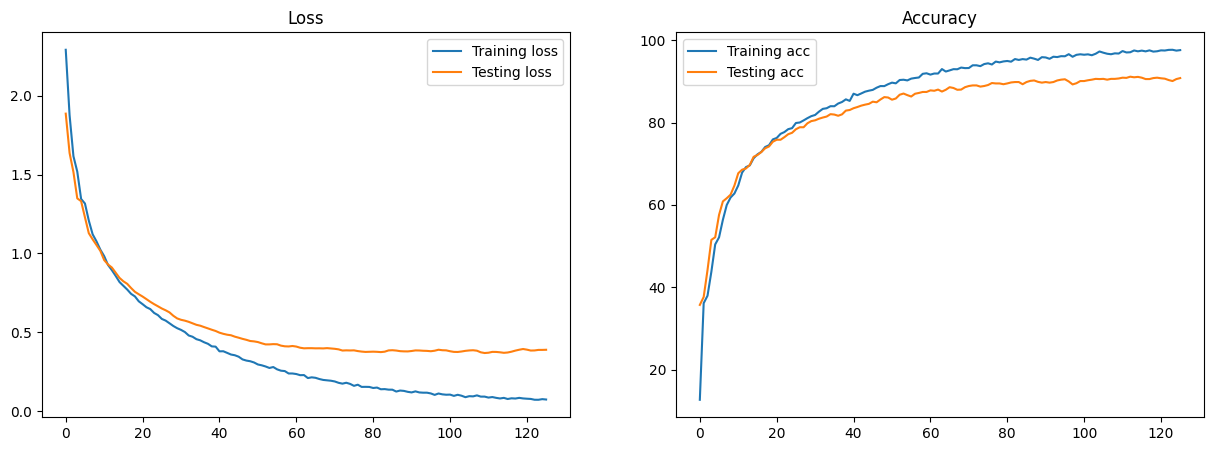

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       214
           1       0.91      0.96      0.94       222
           2       0.84      0.89      0.86       196
           3       0.87      0.88      0.88       213
           4       0.91      0.90      0.91       213
           5       0.91      0.89      0.90       211
           6       0.95      0.95      0.95       187
           7       0.92      0.92      0.92       181
           8       0.94      0.94      0.94       234
           9       0.90      0.80      0.85       205

    accuracy                           0.91      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.91      0.91      0.91      2076



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07362, Acc: 97.59% | Test Loss: 0.38896, Test Acc: 90.80%


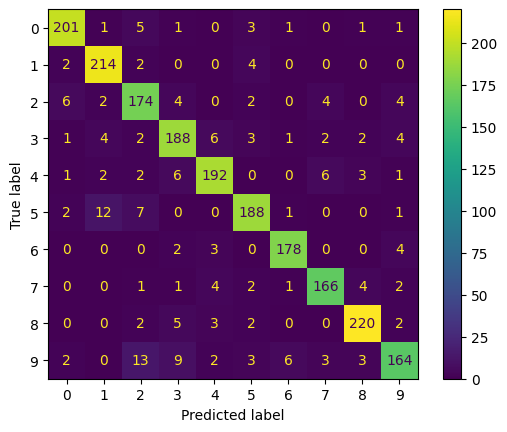

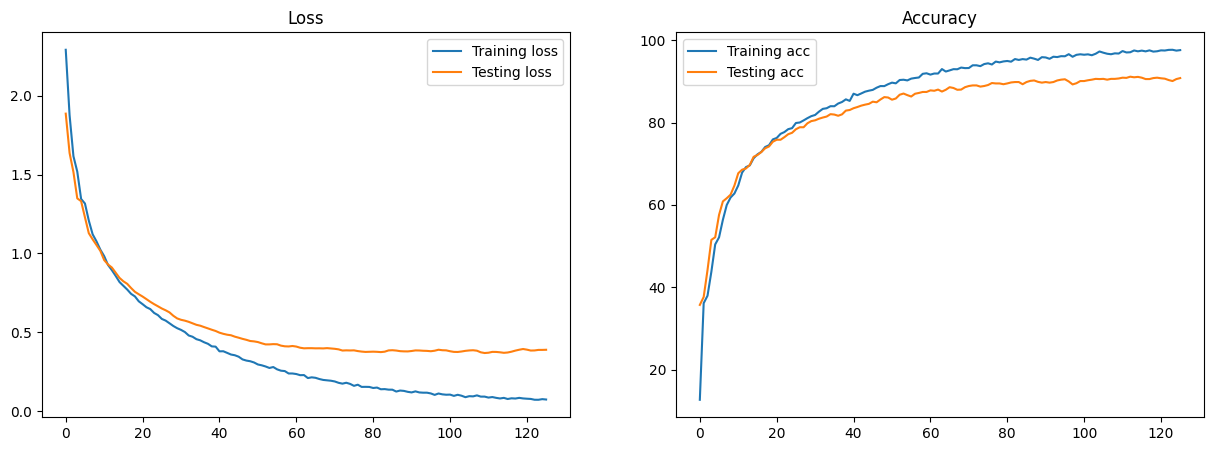

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       214
           1       0.91      0.96      0.94       222
           2       0.84      0.89      0.86       196
           3       0.87      0.88      0.88       213
           4       0.91      0.90      0.91       213
           5       0.91      0.89      0.90       211
           6       0.95      0.95      0.95       187
           7       0.92      0.92      0.92       181
           8       0.94      0.94      0.94       234
           9       0.90      0.80      0.85       205

    accuracy                           0.91      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.91      0.91      0.91      2076



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07362, Acc: 97.59% | Test Loss: 0.38896, Test Acc: 90.80%


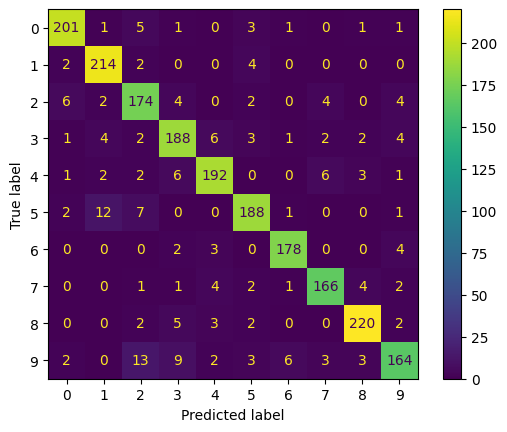

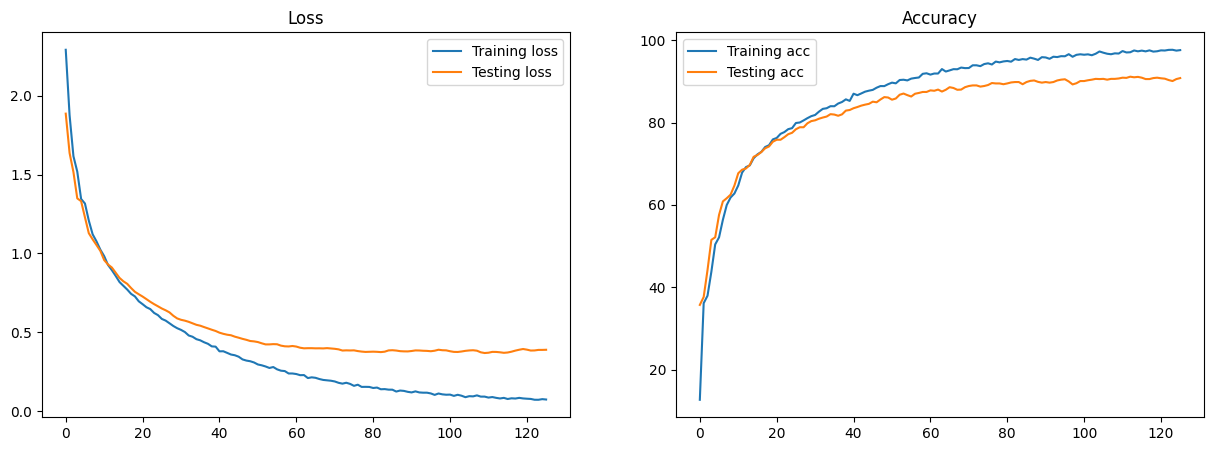

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       214
           1       0.91      0.96      0.94       222
           2       0.84      0.89      0.86       196
           3       0.87      0.88      0.88       213
           4       0.91      0.90      0.91       213
           5       0.91      0.89      0.90       211
           6       0.95      0.95      0.95       187
           7       0.92      0.92      0.92       181
           8       0.94      0.94      0.94       234
           9       0.90      0.80      0.85       205

    accuracy                           0.91      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.91      0.91      0.91      2076



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07362, Acc: 97.59% | Test Loss: 0.38896, Test Acc: 90.80%


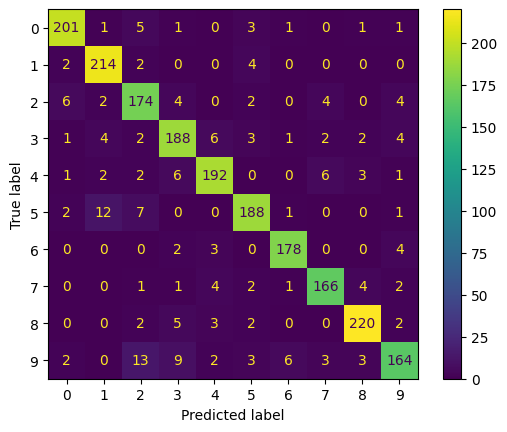

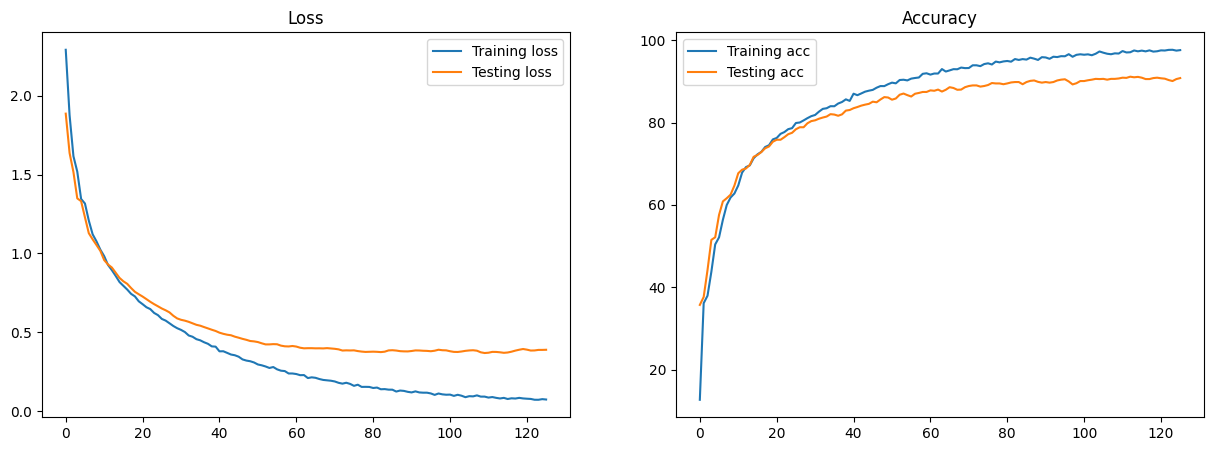

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       214
           1       0.91      0.96      0.94       222
           2       0.84      0.89      0.86       196
           3       0.87      0.88      0.88       213
           4       0.91      0.90      0.91       213
           5       0.91      0.89      0.90       211
           6       0.95      0.95      0.95       187
           7       0.92      0.92      0.92       181
           8       0.94      0.94      0.94       234
           9       0.90      0.80      0.85       205

    accuracy                           0.91      2076
   macro avg       0.91      0.91      0.91      2076
weighted avg       0.91      0.91      0.91      2076



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07142, Acc: 97.43% | Test Loss: 0.35014, Test Acc: 91.54%


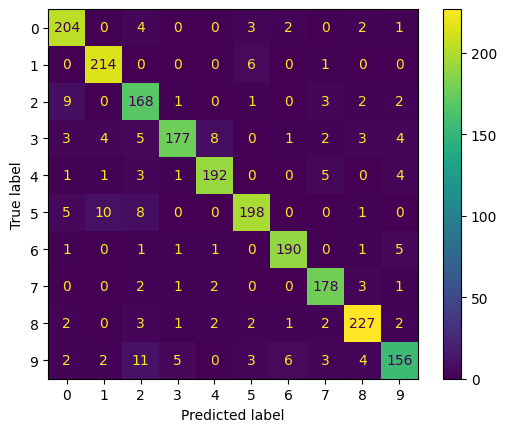

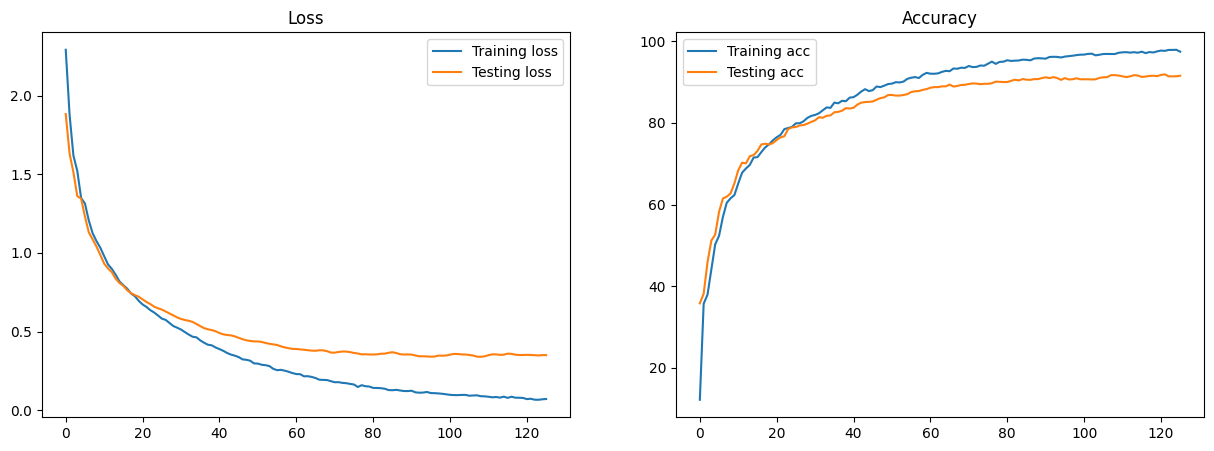

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       216
           1       0.93      0.97      0.95       221
           2       0.82      0.90      0.86       186
           3       0.95      0.86      0.90       207
           4       0.94      0.93      0.93       207
           5       0.93      0.89      0.91       222
           6       0.95      0.95      0.95       200
           7       0.92      0.95      0.93       187
           8       0.93      0.94      0.94       242
           9       0.89      0.81      0.85       192

    accuracy                           0.92      2080
   macro avg       0.92      0.91      0.91      2080
weighted avg       0.92      0.92      0.92      2080



/tmp/ipykernel_12022/2128073614.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07142, Acc: 97.43% | Test Loss: 0.35014, Test Acc: 91.54%


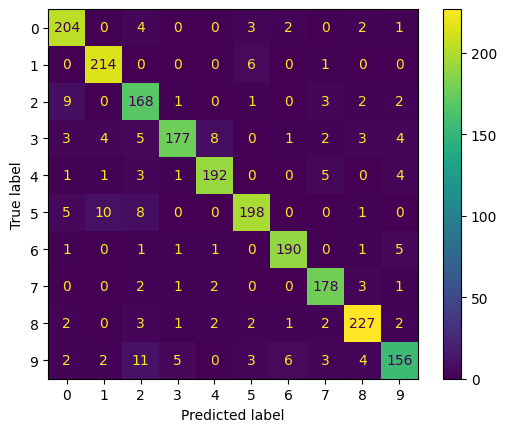

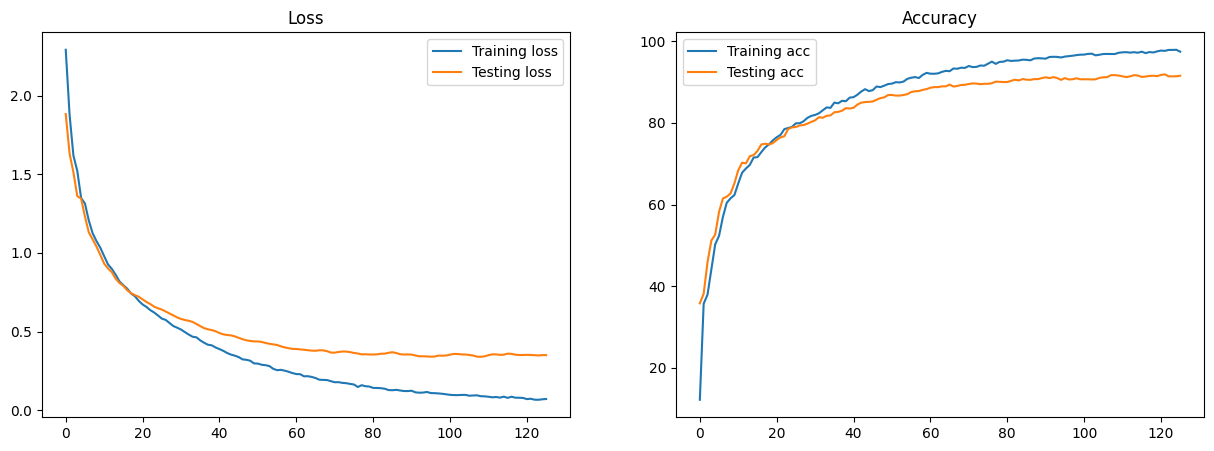

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       216
           1       0.93      0.97      0.95       221
           2       0.82      0.90      0.86       186
           3       0.95      0.86      0.90       207
           4       0.94      0.93      0.93       207
           5       0.93      0.89      0.91       222
           6       0.95      0.95      0.95       200
           7       0.92      0.95      0.93       187
           8       0.93      0.94      0.94       242
           9       0.89      0.81      0.85       192

    accuracy                           0.92      2080
   macro avg       0.92      0.91      0.91      2080
weighted avg       0.92      0.92      0.92      2080



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06858, Acc: 97.71% | Test Loss: 0.37445, Test Acc: 91.59%


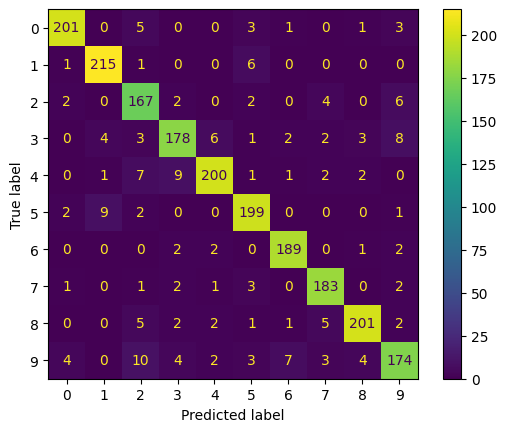

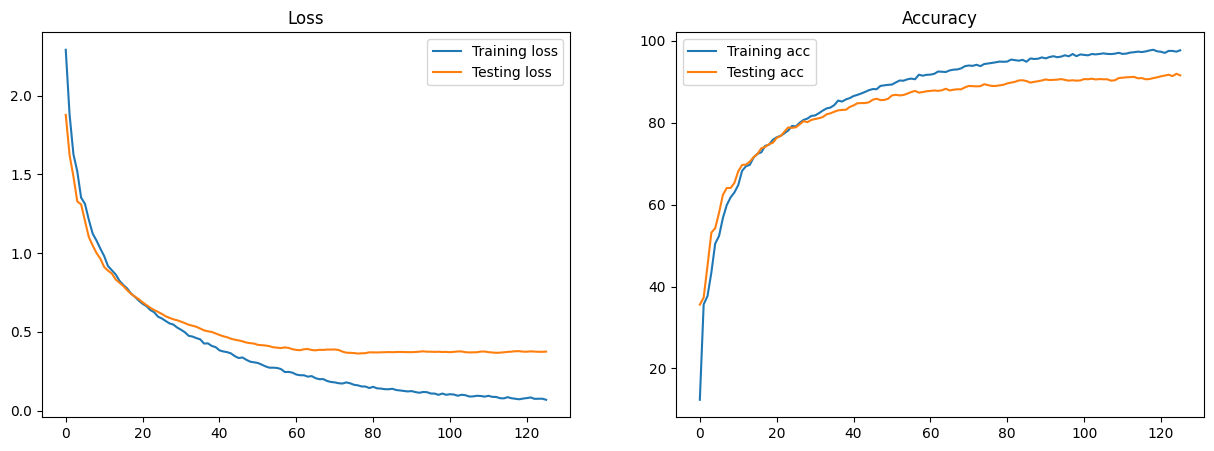

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       214
           1       0.94      0.96      0.95       223
           2       0.83      0.91      0.87       183
           3       0.89      0.86      0.88       207
           4       0.94      0.90      0.92       223
           5       0.91      0.93      0.92       213
           6       0.94      0.96      0.95       196
           7       0.92      0.95      0.93       193
           8       0.95      0.92      0.93       219
           9       0.88      0.82      0.85       211

    accuracy                           0.92      2082
   macro avg       0.92      0.92      0.92      2082
weighted avg       0.92      0.92      0.92      2082



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07117, Acc: 97.63% | Test Loss: 0.39442, Test Acc: 90.92%


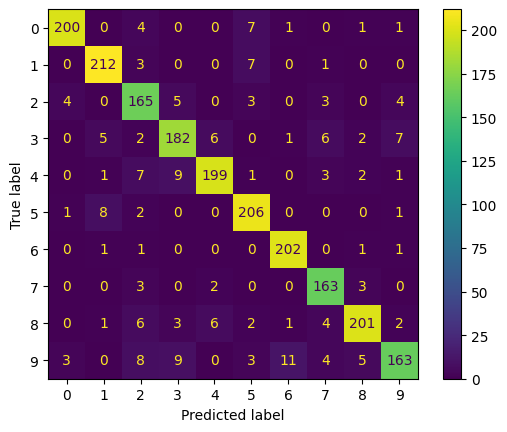

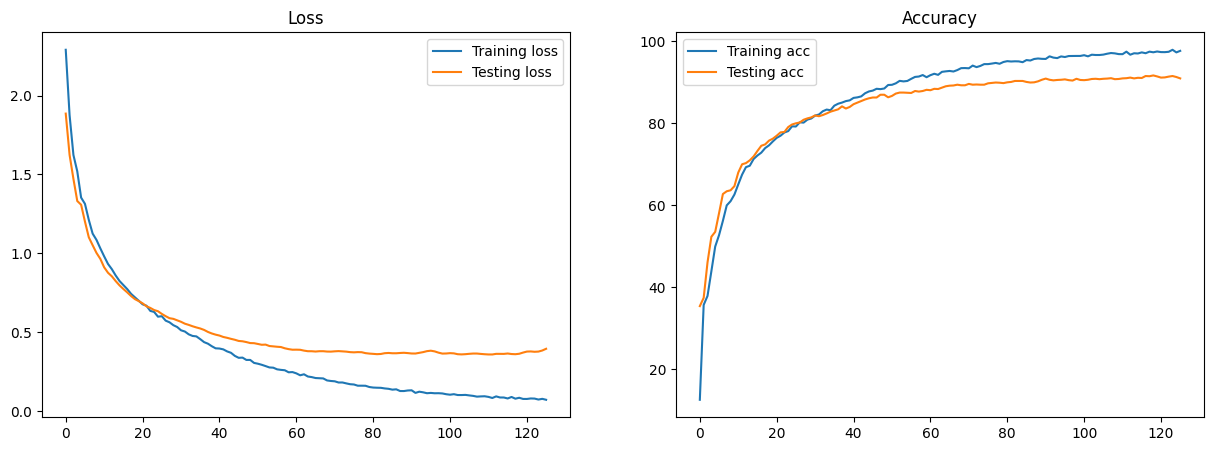

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       214
           1       0.93      0.95      0.94       223
           2       0.82      0.90      0.86       184
           3       0.88      0.86      0.87       211
           4       0.93      0.89      0.91       223
           5       0.90      0.94      0.92       218
           6       0.94      0.98      0.96       206
           7       0.89      0.95      0.92       171
           8       0.93      0.89      0.91       226
           9       0.91      0.79      0.84       206

    accuracy                           0.91      2082
   macro avg       0.91      0.91      0.91      2082
weighted avg       0.91      0.91      0.91      2082



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07213, Acc: 97.61% | Test Loss: 0.34931, Test Acc: 90.98%


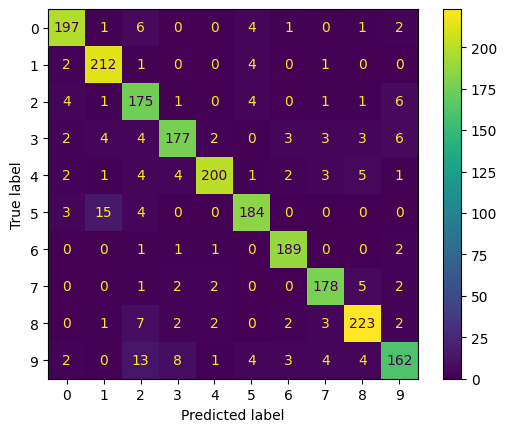

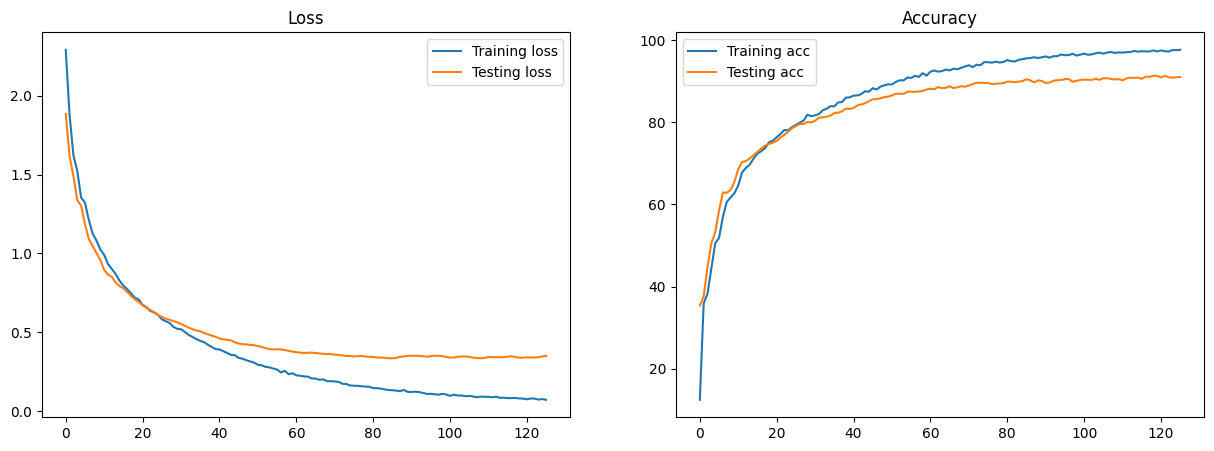

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       212
           1       0.90      0.96      0.93       220
           2       0.81      0.91      0.86       193
           3       0.91      0.87      0.89       204
           4       0.96      0.90      0.93       223
           5       0.92      0.89      0.90       206
           6       0.94      0.97      0.96       194
           7       0.92      0.94      0.93       190
           8       0.92      0.92      0.92       242
           9       0.89      0.81      0.84       201

    accuracy                           0.91      2085
   macro avg       0.91      0.91      0.91      2085
weighted avg       0.91      0.91      0.91      2085



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07835, Acc: 97.32% | Test Loss: 0.43961, Test Acc: 90.68%


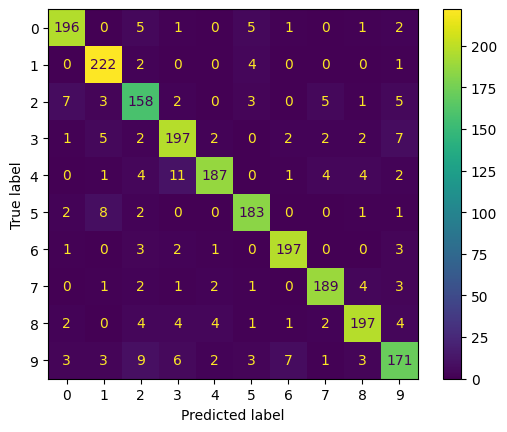

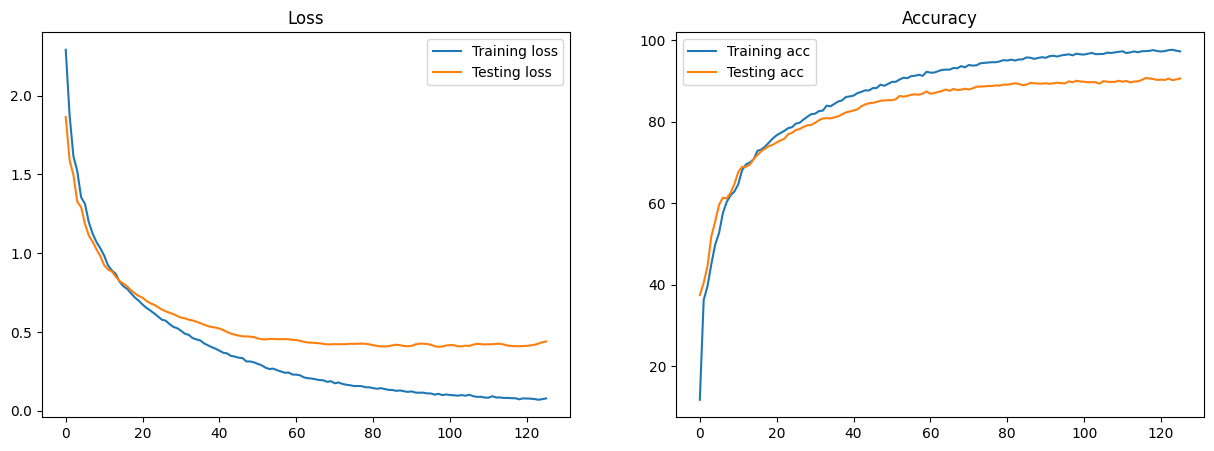

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       211
           1       0.91      0.97      0.94       229
           2       0.83      0.86      0.84       184
           3       0.88      0.90      0.89       220
           4       0.94      0.87      0.91       214
           5       0.92      0.93      0.92       197
           6       0.94      0.95      0.95       207
           7       0.93      0.93      0.93       203
           8       0.92      0.90      0.91       219
           9       0.86      0.82      0.84       208

    accuracy                           0.91      2092
   macro avg       0.91      0.91      0.91      2092
weighted avg       0.91      0.91      0.91      2092



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08182, Acc: 97.26% | Test Loss: 0.34571, Test Acc: 91.49%


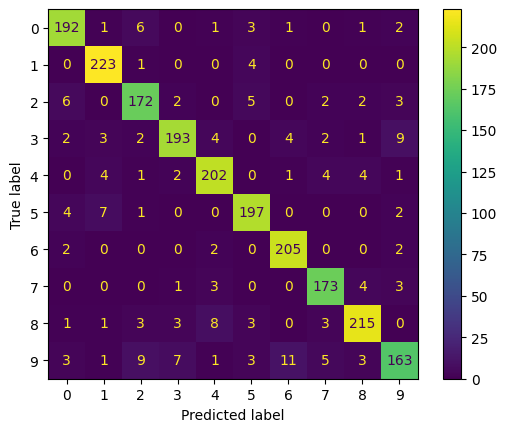

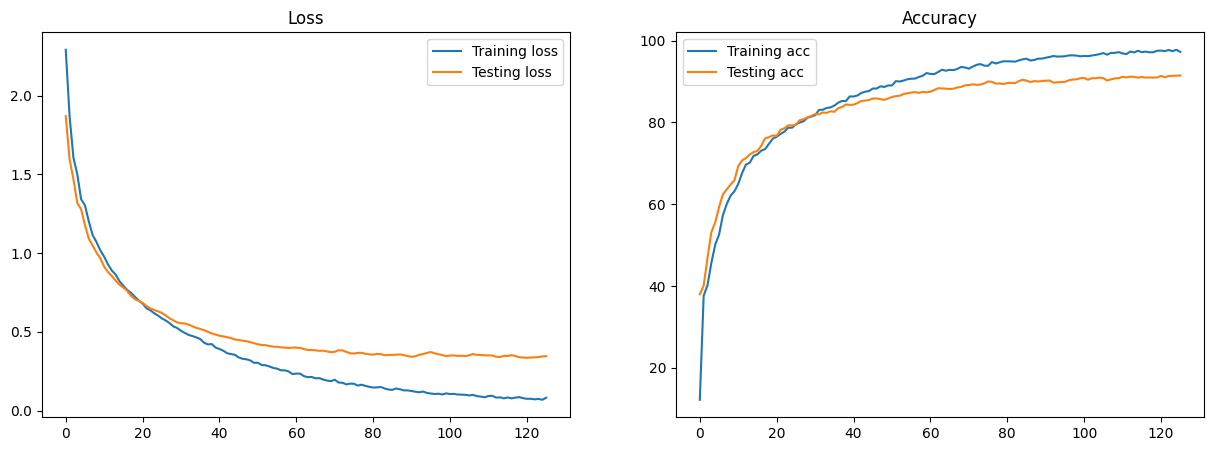

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       207
           1       0.93      0.98      0.95       228
           2       0.88      0.90      0.89       192
           3       0.93      0.88      0.90       220
           4       0.91      0.92      0.92       219
           5       0.92      0.93      0.92       211
           6       0.92      0.97      0.95       211
           7       0.92      0.94      0.93       184
           8       0.93      0.91      0.92       237
           9       0.88      0.79      0.83       206

    accuracy                           0.91      2115
   macro avg       0.91      0.91      0.91      2115
weighted avg       0.91      0.91      0.91      2115



/tmp/ipykernel_12022/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06804, Acc: 97.62% | Test Loss: 0.33894, Test Acc: 91.72%


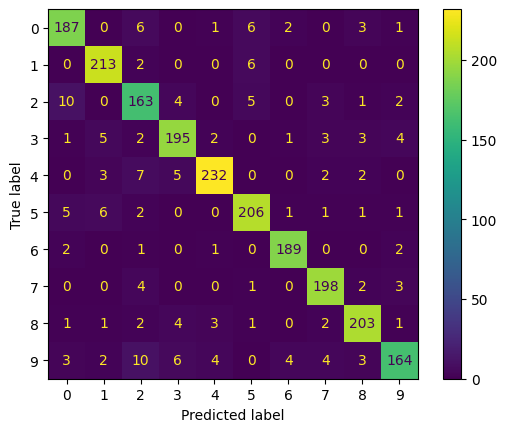

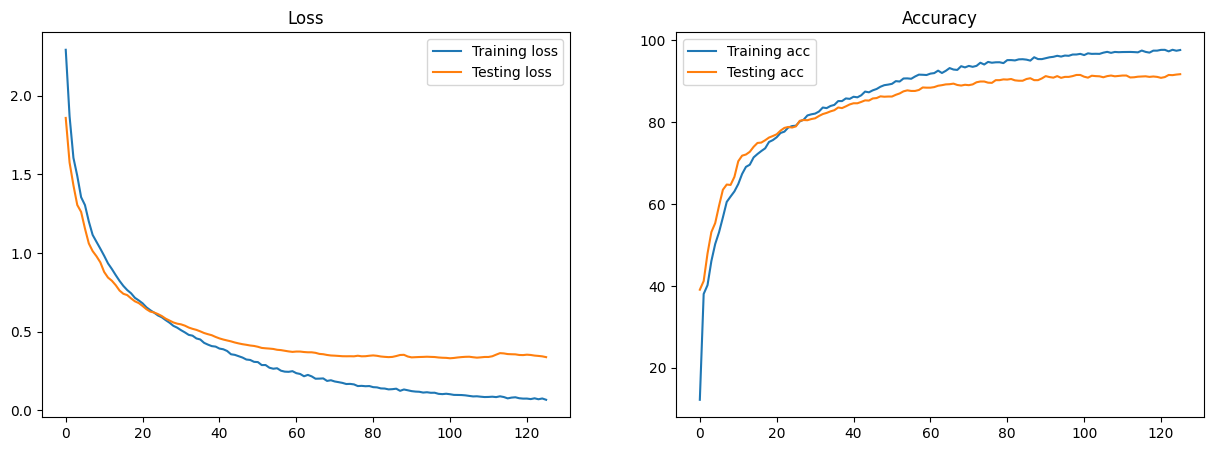

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       206
           1       0.93      0.96      0.94       221
           2       0.82      0.87      0.84       188
           3       0.91      0.90      0.91       216
           4       0.95      0.92      0.94       251
           5       0.92      0.92      0.92       223
           6       0.96      0.97      0.96       195
           7       0.93      0.95      0.94       208
           8       0.93      0.93      0.93       218
           9       0.92      0.82      0.87       200

    accuracy                           0.92      2126
   macro avg       0.92      0.92      0.92      2126
weighted avg       0.92      0.92      0.92      2126



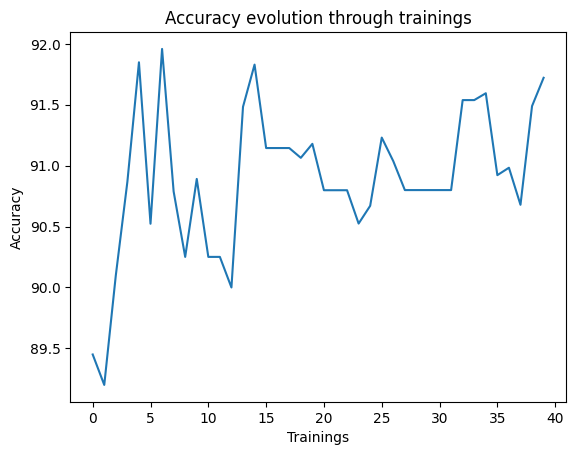

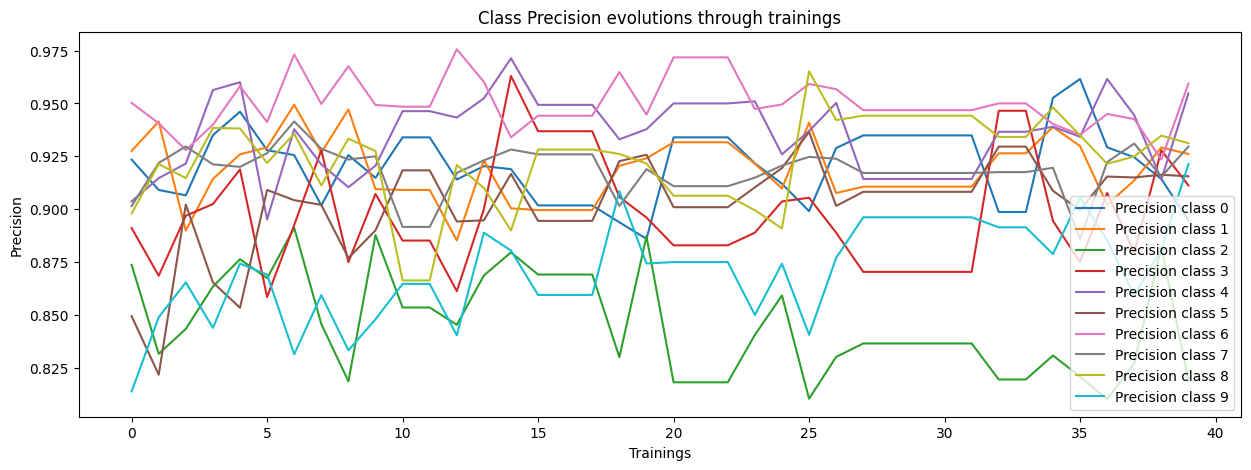

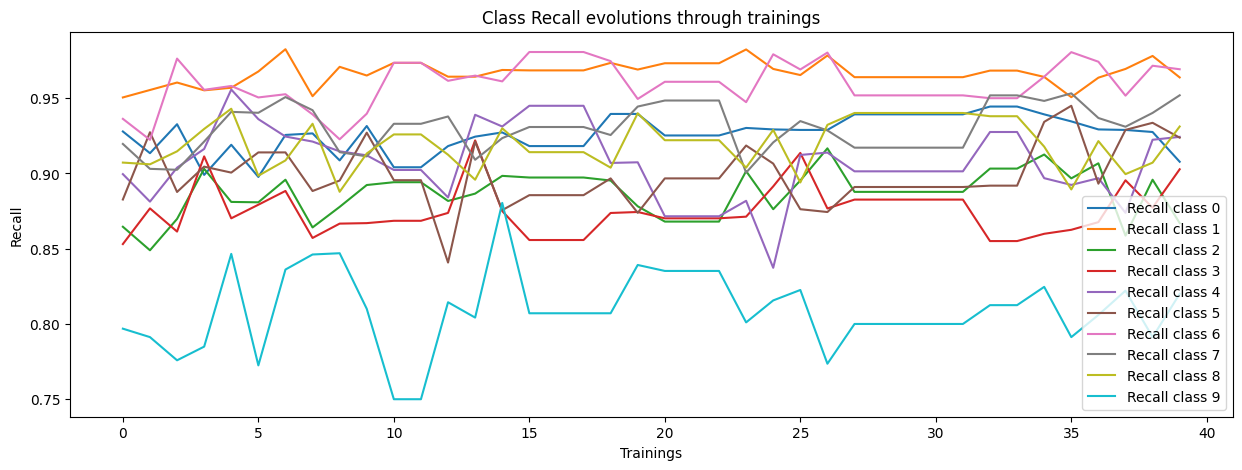

In [15]:
# 1. Data
seuil = 0.8 # TODO Boucler en changeant le seuil
# TODO: Plot les évolutions !

test_acc_history = []

precision_history = {}
recall_history = {}
for i in range(10):
      precision_history[i] = []
      recall_history[i] = []

base_df = pd.read_csv('./resources/original_dataset.csv')
# TODO Faire en sorte que boucle sur chaque genre au fur et a mesure pour garder l'équilibrage du dataset
for genre in os.listdir('./extracted_drive_dataset/'):
    for extracted_features in os.listdir(f'./extracted_drive_dataset/{genre}/'):
            kept_df = pd.DataFrame(columns=column_names)
            dataframe = pd.read_csv(f"./extracted_drive_dataset/{genre}/{extracted_features}")
            # 2. Model
            my_model = MusicClassifier(input_features=55, output_features=10)
            my_model.load_state_dict(
                torch.load(
                    f="./resources/actual_model_fast.pth", map_location=torch.device("cpu")
                )
            )
            dataframe.drop(columns=['label'], inplace=True)
            
            # 3. Prediction
            result, raw_results = predict(my_model, dataframe, genre_mapping, real_class=genre)

            # 4. Filter new data
            kept_df = filter_data(kept_df, seuil, raw_results, dataframe, real_class=int(genre))
            
            # 4.1 Concat with original dataset
            base_df = pd.concat([base_df, kept_df], axis=0)

            # 5. Training loop and 6.1 metrics
            test_acc, precision, recall = training_loop(MusicClassifier, df=base_df)

            for i in range(10):
                  precision_history[i].append(precision[i])
                  recall_history[i].append(recall[i])

            # 6.2 Extra metrics
            test_acc_history.append(test_acc)

# Évolution de l'accuracy
plot_accuracy_evolution(test_acc_history)

# Évolution de la précision, recall et f1-score
plot_metrics_evolution(precision_history, metrics_name="Precision")
plot_metrics_evolution(recall_history, metrics_name="Recall")
# plot_precision_evolution(precision_history)
# plot_precision_evolution(recall_history)


# TODO Afficher somme des precision, recall et f1 score
# TODO plot des graphs d'évolutions (des sommes et spécifique !)
# Évolution du recal